In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import heapq

In [2]:
size = (30, 50)
obstacles = [(5, 5, 10, 10), (20, 30, 25, 45), (15, 0, 20, 5)]#, (15, 15, 20, 20)]
start = (0, 0)
goal = (29, 40)

In [3]:
class Node:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.parent_node = None

In [4]:
def is_within_obstacles(point, obstacles):
  for (x1, y1, x2, y2) in obstacles:
    if x1<=point[0]<=x2 and y1<=point[1]<=y2:
      return True
  return False

def distance(point1, point2):
  return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def nearest_node(nodes, random_point):
  return min(nodes, key=lambda node: distance((node.x, node.y), random_point))

def steer(from_node, to_point, step_size=1):
  if distance((from_node.x, from_node.y), to_point)<step_size:
    return Node(to_point[0], to_point[1])
  else:
    theta = np.arctan2(to_point[1]-from_node.y, to_point[0]-from_node.x)
    return Node(from_node.x + step_size*np.cos(theta), from_node.y + step_size*np.sin(theta))

""" Check if the path between node1 and node2 is valid by interpolating points along the way. """
def is_valid_path(node1, node2, obstacles):
  steps = int(distance((node1.x, node1.y), (node2.x, node2.y))/0.5)  # Smaller steps for more accuracy

  for i in range(1, steps + 1):
    inter_x = node1.x + i*(node2.x-node1.x)/steps
    inter_y = node1.y + i*(node2.y-node1.y)/steps

    if is_within_obstacles((inter_x, inter_y), obstacles):
      return False
  return True


def plot(nodes=None, path=None):
    fig, ax = plt.subplots()
    if nodes:
      for node in nodes:
          if node.parent_node:
              plt.plot([node.x, node.parent_node.x], [node.y, node.parent_node.y], "g-", linewidth=0.5)
    for (ox, oy, ex, ey) in obstacles:
        ax.add_patch(plt.Rectangle((ox, oy), ex-ox, ey-oy, color="red"))
    if path:
        plt.plot([node.x for node in path], [node.y for node in path], "b-", linewidth=2)  # Highlight path in blue
    plt.plot(start[0], start[1], "bo")  # Start
    plt.plot(goal[0], goal[1], "ro")  # Goal
    plt.grid(True)
    plt.show()

In [5]:
def rrt(step_size=3, max_nodes=10000):
    nodes = [Node(start[0], start[1])]
    while len(nodes) < max_nodes:
        random_point = (random.randint(0, size[0] - 1), random.randint(0, size[1] - 1))
        if is_within_obstacles(random_point, obstacles):
            continue
        nearest = nearest_node(nodes, random_point)
        new_node = steer(nearest, random_point, step_size)
        if not is_within_obstacles((new_node.x, new_node.y), obstacles) and is_valid_path(nearest, new_node, obstacles):
            new_node.parent_node = nearest
            nodes.append(new_node)
            if distance((new_node.x, new_node.y), goal) <= 2:#step_size:
                return nodes, new_node
    return nodes, None  # Return None if max_nodes reached without finding a path

In [6]:
def create_initial_population(population_size=10, start=(0,0), goal=(29, 40) ,plot_paths = True):
  population = []
  # solution = []
  for i in range(population_size):
    nodes, final_node = rrt()
    path = []
    if final_node:
        while final_node.parent_node:
            path.append(final_node)
            final_node = final_node.parent_node
        path.append(final_node)
        path.reverse()
    if plot_paths:
      print(path)
      plot(nodes, path)
    population.append(path)
  return population

In [7]:
def fitness_function(path):
    coordinates = [(node.x, node.y) for node in path]
    wt = 1
    euc_dist = 0
    for i in range(len(coordinates) - 1):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i+1]
        dist_ = math.sqrt((x2-x1)**2 +(y2-y1)**2)
        euc_dist += dist_
        if euc_dist > 0:
            F = 1 / (wt*euc_dist)
        else:
            F = float('inf')
    return euc_dist, F

In [8]:
def calcualte_fitness_of_population(population):
  fitness = []
  for index, path in enumerate(population):
    euc_dist, F = fitness_function(path)
    fitness.append(F)
  return fitness

In [9]:
def selection(fitness, population):
  P1 = []
  P2 = []
  while(fitness):
    max_fitness = max(fitness)
    index = fitness.index(max_fitness)
    fitness.pop(index)
    P1.append(population.pop(index))

    l = len(fitness)
    i = random.randint(0, l-1)
    fitness.pop(i)
    P2.append(population.pop(i))
  return P1, P2

In [10]:
def best_selection(fitness, population):
  P1 = []
  P2 = []
  while(fitness):
    max_fitness = max(fitness)
    index = fitness.index(max_fitness)
    fitness.pop(index)
    P1.append(population.pop(index))

    max_fitness = max(fitness)
    index = fitness.index(max_fitness)
    fitness.pop(index)
    P2.append(population.pop(index))

  return P1, P2

In [11]:
def plot_best_solution(fitness, population, plot_graph=False):
  max_fitness = max(fitness)
  index = fitness.index(max_fitness)
  best_path = population[index]
  print(f"Fitness: {max_fitness}")
  if plot_graph:
    plot(path=best_path)
  return max_fitness

In [12]:
#CrossOver points
def crossoverpt(parent1,parent2):
    minval=2
    offspring1=[]
    offspring2=[]
    #range defined in such a way that it ignores inital and final points
    for pt1 in range(3, len(parent1)-3):
        for pt2 in range(3, len(parent2)-3):
            #Calculating  distance between every nodes of 2 paths and selecting the min distance path points
            if (math.sqrt((parent1[pt1].x-parent2[pt2].x)**2+(parent1[pt1].y-parent2[pt2].y)**2))<minval:
                # print("DISTANCE: ")
                # print(math.sqrt((parent1[pt1].x-parent2[pt2].x)**2+(parent1[pt1].y-parent2[pt2].y)**2))
                # print("parent1 point: ", parent1[pt1].x, parent1[pt1].y)
                # print("parent2 point: " , parent2[pt2].x, parent2[pt2].y)
                # if (minval>math.sqrt((parent1[1][pt1].x-parent2[1][pt2].x)**2+(parent1[1][pt1].y-parent2[1][pt2].y)**2)):
                minval=math.sqrt((parent1[pt1].x-parent2[pt2].x)**2+(parent1[pt1].y-parent2[pt2].y)**2)
                #storing path points indexes so to use them to crossover
                parent1_point_idx=pt1
                parent2_point_idx=pt2

    # Pruning the path and making crossover based on the indexes calculated
    for i in range(parent1_point_idx+1):
        offspring1.append(Node(parent1[i].x,parent1[i].y))
    for i in range(parent2_point_idx,len(parent2)):
        offspring1.append(Node(parent2[i].x,parent2[i].y))

    for i in range(parent2_point_idx+1):
        offspring2.append(Node(parent2[i].x,parent2[i].y))
    for i in range(parent1_point_idx,len(parent1)):
        offspring2.append(Node(parent1[i].x,parent1[i].y))


    #Returning offsprings
    return offspring1,offspring2

In [13]:
def elimination(fitness, population):
  num_eliminations = int(0.1*len(fitness))
  for i in range(0, num_eliminations):
    min_fitness = min(fitness)
    index = fitness.index(min_fitness)
    fitness.pop(index)
    population.pop(index)
  return fitness, population


[<__main__.Node object at 0x7fc48d28ea70>, <__main__.Node object at 0x7fc48d28c700>, <__main__.Node object at 0x7fc48d28f460>, <__main__.Node object at 0x7fc48d28e860>, <__main__.Node object at 0x7fc48d28e770>, <__main__.Node object at 0x7fc48d28e050>, <__main__.Node object at 0x7fc48d28dde0>, <__main__.Node object at 0x7fc48d28c970>, <__main__.Node object at 0x7fc48d28e080>, <__main__.Node object at 0x7fc48d28d240>, <__main__.Node object at 0x7fc48d28c460>, <__main__.Node object at 0x7fc48d28e380>, <__main__.Node object at 0x7fc48d28c820>, <__main__.Node object at 0x7fc48d28d8a0>, <__main__.Node object at 0x7fc48d28cd60>, <__main__.Node object at 0x7fc48d28c580>, <__main__.Node object at 0x7fc48d28f850>, <__main__.Node object at 0x7fc48d28de40>, <__main__.Node object at 0x7fc48d28e560>, <__main__.Node object at 0x7fc48d28d210>, <__main__.Node object at 0x7fc48d28c2e0>, <__main__.Node object at 0x7fc48d27c9a0>, <__main__.Node object at 0x7fc48d27f0a0>]


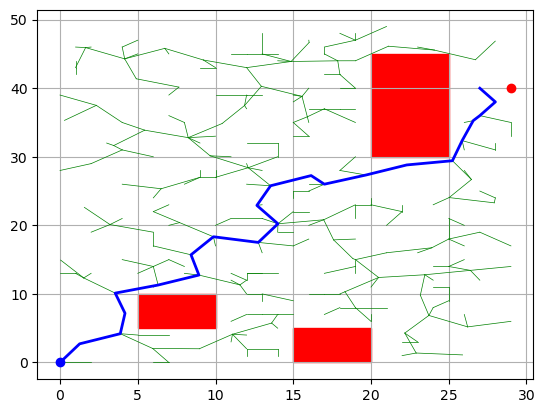

[<__main__.Node object at 0x7fc48d280c40>, <__main__.Node object at 0x7fc48d280ca0>, <__main__.Node object at 0x7fc48d27fdf0>, <__main__.Node object at 0x7fc48af4f070>, <__main__.Node object at 0x7fc48af4f0d0>, <__main__.Node object at 0x7fc48af4f250>, <__main__.Node object at 0x7fc48af4f760>, <__main__.Node object at 0x7fc48af4f370>, <__main__.Node object at 0x7fc48af4f580>, <__main__.Node object at 0x7fc48af4f400>, <__main__.Node object at 0x7fc48af4f4f0>, <__main__.Node object at 0x7fc48af4f160>, <__main__.Node object at 0x7fc48af4f310>, <__main__.Node object at 0x7fc48afc18a0>, <__main__.Node object at 0x7fc48afc0d60>, <__main__.Node object at 0x7fc48ae6da80>, <__main__.Node object at 0x7fc48ae6dc60>, <__main__.Node object at 0x7fc48ae6fa90>, <__main__.Node object at 0x7fc48ae8d330>, <__main__.Node object at 0x7fc48ae8e470>, <__main__.Node object at 0x7fc48ae8f970>]


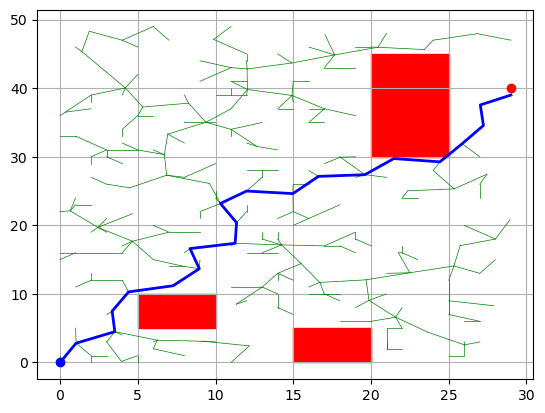

[<__main__.Node object at 0x7fc48d28f970>, <__main__.Node object at 0x7fc48d28e740>, <__main__.Node object at 0x7fc48d28c3a0>, <__main__.Node object at 0x7fc48af4f4c0>, <__main__.Node object at 0x7fc48af4fac0>, <__main__.Node object at 0x7fc48af4fe20>, <__main__.Node object at 0x7fc48af4ff10>, <__main__.Node object at 0x7fc48af4faf0>, <__main__.Node object at 0x7fc48af4fee0>, <__main__.Node object at 0x7fc48d27fa30>, <__main__.Node object at 0x7fc48d27fa00>, <__main__.Node object at 0x7fc48af9ac50>, <__main__.Node object at 0x7fc4894a7040>, <__main__.Node object at 0x7fc4894a77f0>, <__main__.Node object at 0x7fc4894a7a30>, <__main__.Node object at 0x7fc4894a7d30>, <__main__.Node object at 0x7fc48af18550>, <__main__.Node object at 0x7fc48af18d60>, <__main__.Node object at 0x7fc48af1a680>, <__main__.Node object at 0x7fc48af1abf0>, <__main__.Node object at 0x7fc48af39630>]


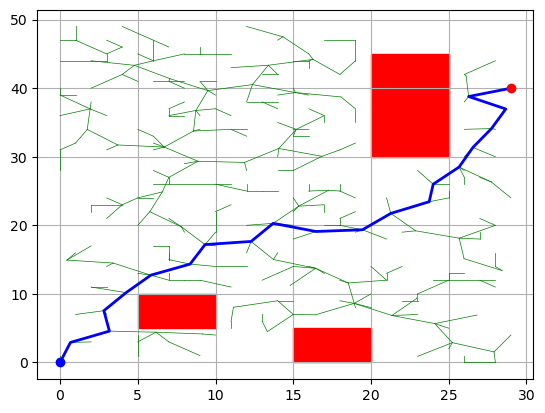

[<__main__.Node object at 0x7fc48ae6dc00>, <__main__.Node object at 0x7fc48ae6db70>, <__main__.Node object at 0x7fc48ae6db10>, <__main__.Node object at 0x7fc4893c2da0>, <__main__.Node object at 0x7fc4893c3340>, <__main__.Node object at 0x7fc4893c32b0>, <__main__.Node object at 0x7fc4893c3310>, <__main__.Node object at 0x7fc4893c2f80>, <__main__.Node object at 0x7fc4893c2f50>, <__main__.Node object at 0x7fc4893c2d40>, <__main__.Node object at 0x7fc4893c32e0>, <__main__.Node object at 0x7fc4893c2e60>, <__main__.Node object at 0x7fc4893c3250>, <__main__.Node object at 0x7fc48af4fd60>, <__main__.Node object at 0x7fc48af99ff0>, <__main__.Node object at 0x7fc48ae18d00>, <__main__.Node object at 0x7fc48926c5b0>, <__main__.Node object at 0x7fc48926ca60>, <__main__.Node object at 0x7fc48926c9d0>, <__main__.Node object at 0x7fc48926d060>, <__main__.Node object at 0x7fc48926e350>, <__main__.Node object at 0x7fc48926f4f0>, <__main__.Node object at 0x7fc48926fbb0>, <__main__.Node object at 0x7fc489

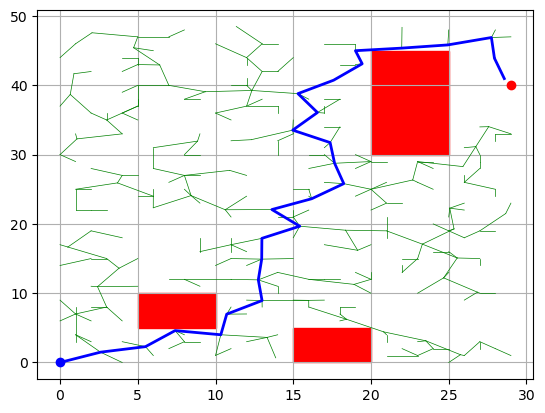

[<__main__.Node object at 0x7fc488fbffa0>, <__main__.Node object at 0x7fc488fbf520>, <__main__.Node object at 0x7fc488fbfc40>, <__main__.Node object at 0x7fc488fbfaf0>, <__main__.Node object at 0x7fc488fbf7c0>, <__main__.Node object at 0x7fc488fbf8b0>, <__main__.Node object at 0x7fc488fbf820>, <__main__.Node object at 0x7fc488fbf850>, <__main__.Node object at 0x7fc488fbf700>, <__main__.Node object at 0x7fc488fbfc70>, <__main__.Node object at 0x7fc488e088b0>, <__main__.Node object at 0x7fc488e08910>, <__main__.Node object at 0x7fc48af9ad40>, <__main__.Node object at 0x7fc4894a7340>, <__main__.Node object at 0x7fc4894a7670>, <__main__.Node object at 0x7fc488dee680>, <__main__.Node object at 0x7fc488dee350>, <__main__.Node object at 0x7fc488e6d7e0>, <__main__.Node object at 0x7fc488e6dc90>, <__main__.Node object at 0x7fc488e6dcc0>, <__main__.Node object at 0x7fc488e6df30>, <__main__.Node object at 0x7fc488e6e500>, <__main__.Node object at 0x7fc488e6e740>, <__main__.Node object at 0x7fc488

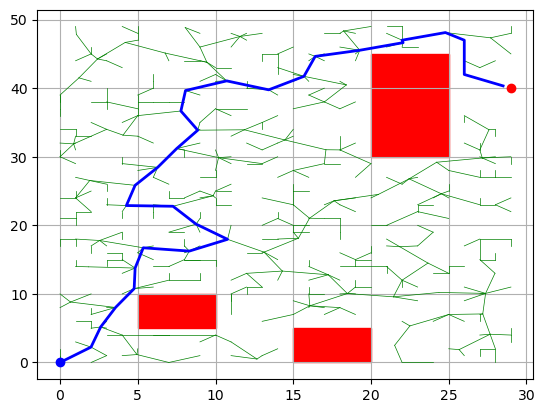

[<__main__.Node object at 0x7fc489219570>, <__main__.Node object at 0x7fc48ae18c70>, <__main__.Node object at 0x7fc48926d090>, <__main__.Node object at 0x7fc48926d120>, <__main__.Node object at 0x7fc48926cdf0>, <__main__.Node object at 0x7fc48d25a650>, <__main__.Node object at 0x7fc48926cd00>, <__main__.Node object at 0x7fc48d25b760>, <__main__.Node object at 0x7fc48d25add0>, <__main__.Node object at 0x7fc48d25b6a0>, <__main__.Node object at 0x7fc48d25bb20>, <__main__.Node object at 0x7fc48d25bb50>, <__main__.Node object at 0x7fc48d25b5b0>, <__main__.Node object at 0x7fc48d25b010>, <__main__.Node object at 0x7fc48d25b820>, <__main__.Node object at 0x7fc48d28f3d0>, <__main__.Node object at 0x7fc488da1bd0>, <__main__.Node object at 0x7fc488da1f90>, <__main__.Node object at 0x7fc488da26b0>, <__main__.Node object at 0x7fc488da2e60>, <__main__.Node object at 0x7fc48aea4820>]


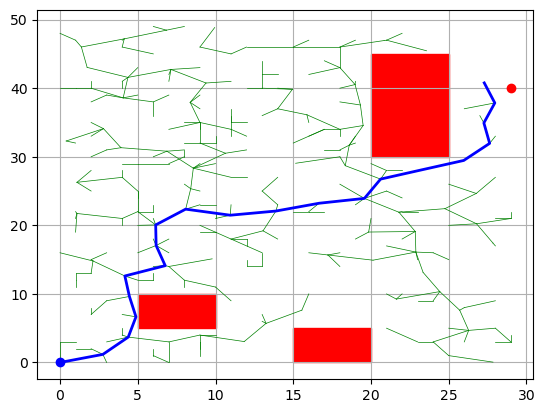

[<__main__.Node object at 0x7fc48af987f0>, <__main__.Node object at 0x7fc488f57520>, <__main__.Node object at 0x7fc488f57670>, <__main__.Node object at 0x7fc488f576a0>, <__main__.Node object at 0x7fc488f57790>, <__main__.Node object at 0x7fc488f577f0>, <__main__.Node object at 0x7fc488f57820>, <__main__.Node object at 0x7fc488f57730>, <__main__.Node object at 0x7fc488f57be0>, <__main__.Node object at 0x7fc488f57bb0>, <__main__.Node object at 0x7fc488f57a90>, <__main__.Node object at 0x7fc488f57c40>, <__main__.Node object at 0x7fc488e6de10>, <__main__.Node object at 0x7fc488f4a230>, <__main__.Node object at 0x7fc488f4a4a0>, <__main__.Node object at 0x7fc488f4a440>, <__main__.Node object at 0x7fc488f4a140>, <__main__.Node object at 0x7fc488f4a320>, <__main__.Node object at 0x7fc488f4a680>, <__main__.Node object at 0x7fc489328160>, <__main__.Node object at 0x7fc489328e20>, <__main__.Node object at 0x7fc4893294e0>, <__main__.Node object at 0x7fc48932a3b0>, <__main__.Node object at 0x7fc489

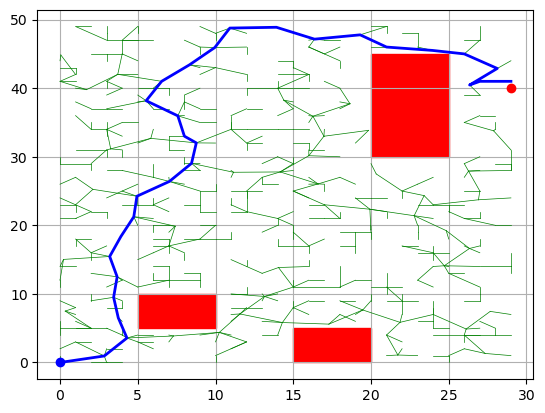

[<__main__.Node object at 0x7fc48d28e8c0>, <__main__.Node object at 0x7fc4c41521a0>, <__main__.Node object at 0x7fc489470d00>, <__main__.Node object at 0x7fc489470af0>, <__main__.Node object at 0x7fc4894712a0>, <__main__.Node object at 0x7fc4894711b0>, <__main__.Node object at 0x7fc4894717b0>, <__main__.Node object at 0x7fc489471630>, <__main__.Node object at 0x7fc489471720>, <__main__.Node object at 0x7fc4894717e0>, <__main__.Node object at 0x7fc4894713c0>, <__main__.Node object at 0x7fc489470eb0>, <__main__.Node object at 0x7fc489471270>, <__main__.Node object at 0x7fc489219150>, <__main__.Node object at 0x7fc48921ace0>, <__main__.Node object at 0x7fc48921b130>, <__main__.Node object at 0x7fc48921b6a0>, <__main__.Node object at 0x7fc48921ba90>, <__main__.Node object at 0x7fc489218cd0>, <__main__.Node object at 0x7fc48d25a8c0>, <__main__.Node object at 0x7fc48b0b3910>, <__main__.Node object at 0x7fc48b0b3130>, <__main__.Node object at 0x7fc48b0b0100>, <__main__.Node object at 0x7fc48d

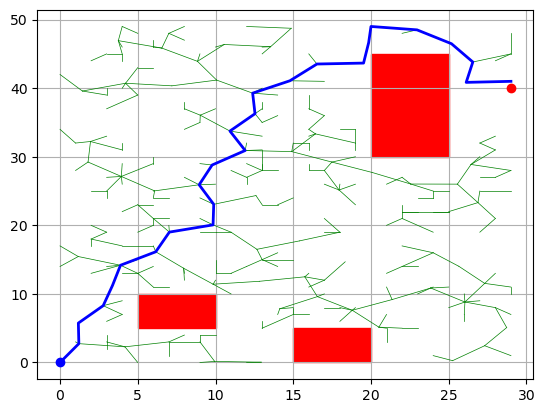

[<__main__.Node object at 0x7fc488da2aa0>, <__main__.Node object at 0x7fc489328040>, <__main__.Node object at 0x7fc488ef3ca0>, <__main__.Node object at 0x7fc488e4d060>, <__main__.Node object at 0x7fc48b0b2140>, <__main__.Node object at 0x7fc48b0b23b0>, <__main__.Node object at 0x7fc488e84b20>, <__main__.Node object at 0x7fc488e84be0>, <__main__.Node object at 0x7fc488e84c70>, <__main__.Node object at 0x7fc488e84ca0>, <__main__.Node object at 0x7fc488e84d90>, <__main__.Node object at 0x7fc488e84e20>, <__main__.Node object at 0x7fc488e85270>, <__main__.Node object at 0x7fc488e85210>, <__main__.Node object at 0x7fc488e85630>, <__main__.Node object at 0x7fc488e85810>, <__main__.Node object at 0x7fc488e866b0>, <__main__.Node object at 0x7fc488e86ad0>, <__main__.Node object at 0x7fc488e86e90>, <__main__.Node object at 0x7fc488e87910>, <__main__.Node object at 0x7fc489208d30>]


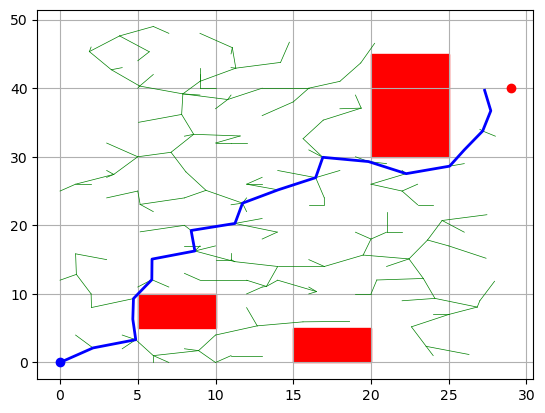

[<__main__.Node object at 0x7fc489347ee0>, <__main__.Node object at 0x7fc4891f54e0>, <__main__.Node object at 0x7fc4891f40d0>, <__main__.Node object at 0x7fc48ae18340>, <__main__.Node object at 0x7fc48ae18160>, <__main__.Node object at 0x7fc48ae187f0>, <__main__.Node object at 0x7fc48ae18a90>, <__main__.Node object at 0x7fc48ae18af0>, <__main__.Node object at 0x7fc48ae18940>, <__main__.Node object at 0x7fc48ae18190>, <__main__.Node object at 0x7fc488e4c2b0>, <__main__.Node object at 0x7fc488e4c490>, <__main__.Node object at 0x7fc488e4c4c0>, <__main__.Node object at 0x7fc488e4f520>, <__main__.Node object at 0x7fc488e4cbb0>, <__main__.Node object at 0x7fc488e4cac0>, <__main__.Node object at 0x7fc488e4d180>, <__main__.Node object at 0x7fc488e4c310>, <__main__.Node object at 0x7fc488e4f4f0>, <__main__.Node object at 0x7fc488e4c040>, <__main__.Node object at 0x7fc488e4c280>, <__main__.Node object at 0x7fc488e4c670>, <__main__.Node object at 0x7fc488e4e7a0>, <__main__.Node object at 0x7fc488

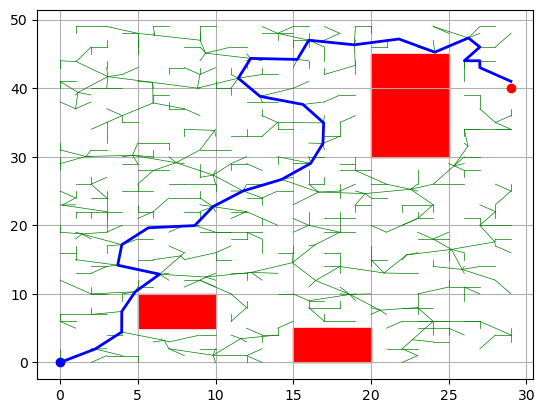

[<__main__.Node object at 0x7fc488e7dab0>, <__main__.Node object at 0x7fc489309b40>, <__main__.Node object at 0x7fc489309c90>, <__main__.Node object at 0x7fc48930a200>, <__main__.Node object at 0x7fc48930a260>, <__main__.Node object at 0x7fc48930a170>, <__main__.Node object at 0x7fc489309db0>, <__main__.Node object at 0x7fc489309ea0>, <__main__.Node object at 0x7fc489309e10>, <__main__.Node object at 0x7fc489309de0>, <__main__.Node object at 0x7fc489309b70>, <__main__.Node object at 0x7fc489309cc0>, <__main__.Node object at 0x7fc48930a290>, <__main__.Node object at 0x7fc488e85c60>, <__main__.Node object at 0x7fc488e85360>, <__main__.Node object at 0x7fc48918eef0>, <__main__.Node object at 0x7fc48918f010>, <__main__.Node object at 0x7fc4895708e0>, <__main__.Node object at 0x7fc489570d00>, <__main__.Node object at 0x7fc4895712a0>, <__main__.Node object at 0x7fc489571630>, <__main__.Node object at 0x7fc489572830>, <__main__.Node object at 0x7fc48952c130>, <__main__.Node object at 0x7fc489

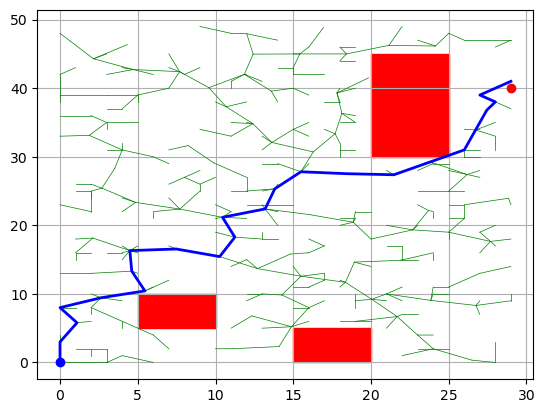

[<__main__.Node object at 0x7fc48aea7e50>, <__main__.Node object at 0x7fc4c41a3790>, <__main__.Node object at 0x7fc4c41a39d0>, <__main__.Node object at 0x7fc488def6a0>, <__main__.Node object at 0x7fc488def9a0>, <__main__.Node object at 0x7fc488def820>, <__main__.Node object at 0x7fc488defd00>, <__main__.Node object at 0x7fc488ded8a0>, <__main__.Node object at 0x7fc488deee30>, <__main__.Node object at 0x7fc48d28c520>, <__main__.Node object at 0x7fc48d28ee30>, <__main__.Node object at 0x7fc48d28fa00>, <__main__.Node object at 0x7fc48d28cac0>, <__main__.Node object at 0x7fc48d28eda0>, <__main__.Node object at 0x7fc48d28fee0>, <__main__.Node object at 0x7fc48d28c100>, <__main__.Node object at 0x7fc48d28eef0>, <__main__.Node object at 0x7fc48d28eec0>, <__main__.Node object at 0x7fc488eb1480>, <__main__.Node object at 0x7fc48ae8f0d0>, <__main__.Node object at 0x7fc48ae8f0a0>, <__main__.Node object at 0x7fc48ae8ca90>, <__main__.Node object at 0x7fc48ae8ff70>, <__main__.Node object at 0x7fc48a

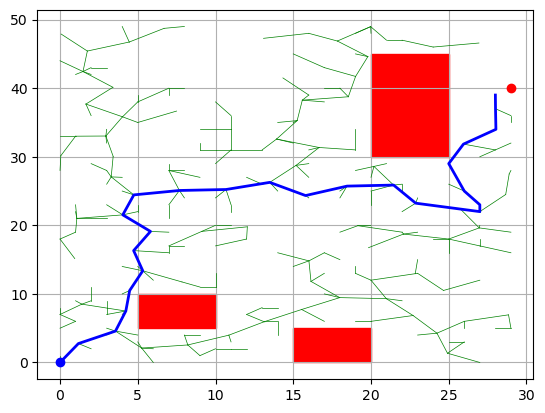

[<__main__.Node object at 0x7fc489570a00>, <__main__.Node object at 0x7fc489570970>, <__main__.Node object at 0x7fc488decd30>, <__main__.Node object at 0x7fc4893dc3d0>, <__main__.Node object at 0x7fc48b0b2380>, <__main__.Node object at 0x7fc48d282140>, <__main__.Node object at 0x7fc48d25a2f0>, <__main__.Node object at 0x7fc48d25b0d0>, <__main__.Node object at 0x7fc48d25b0a0>, <__main__.Node object at 0x7fc48d25b1c0>, <__main__.Node object at 0x7fc48d25b070>, <__main__.Node object at 0x7fc48d25b280>, <__main__.Node object at 0x7fc48d25b6d0>, <__main__.Node object at 0x7fc48d259b40>, <__main__.Node object at 0x7fc48d25a440>, <__main__.Node object at 0x7fc48d25ab30>, <__main__.Node object at 0x7fc488e7cc70>, <__main__.Node object at 0x7fc4891f4a30>, <__main__.Node object at 0x7fc4891f61a0>, <__main__.Node object at 0x7fc4891f7070>, <__main__.Node object at 0x7fc4891f79d0>, <__main__.Node object at 0x7fc4891f78b0>]


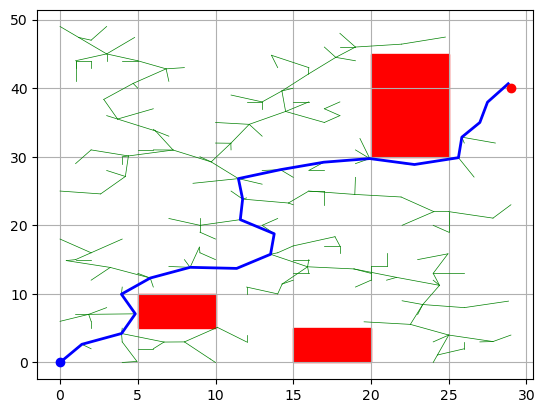

[<__main__.Node object at 0x7fc48af98df0>, <__main__.Node object at 0x7fc48af98b80>, <__main__.Node object at 0x7fc48af9bbe0>, <__main__.Node object at 0x7fc48af9a650>, <__main__.Node object at 0x7fc48af99810>, <__main__.Node object at 0x7fc48af9a470>, <__main__.Node object at 0x7fc48af980a0>, <__main__.Node object at 0x7fc48af983a0>, <__main__.Node object at 0x7fc48af99990>, <__main__.Node object at 0x7fc48af9aad0>, <__main__.Node object at 0x7fc48af995d0>, <__main__.Node object at 0x7fc488f55cc0>, <__main__.Node object at 0x7fc488f554b0>, <__main__.Node object at 0x7fc488f54580>, <__main__.Node object at 0x7fc489209720>, <__main__.Node object at 0x7fc48920af20>, <__main__.Node object at 0x7fc489347640>, <__main__.Node object at 0x7fc489345750>, <__main__.Node object at 0x7fc489345990>, <__main__.Node object at 0x7fc4893461a0>, <__main__.Node object at 0x7fc489347e50>, <__main__.Node object at 0x7fc489345d20>, <__main__.Node object at 0x7fc489344d00>, <__main__.Node object at 0x7fc489

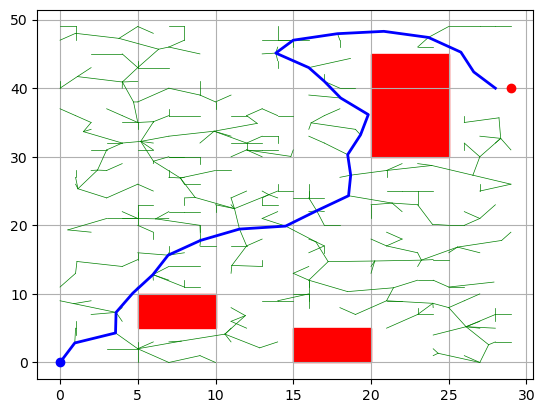

[<__main__.Node object at 0x7fc4892858d0>, <__main__.Node object at 0x7fc489284c10>, <__main__.Node object at 0x7fc4892855d0>, <__main__.Node object at 0x7fc48b01f670>, <__main__.Node object at 0x7fc48b01fd60>, <__main__.Node object at 0x7fc48b01ee90>, <__main__.Node object at 0x7fc48b01f190>, <__main__.Node object at 0x7fc48b01f1c0>, <__main__.Node object at 0x7fc48b01f460>, <__main__.Node object at 0x7fc48b01fcd0>, <__main__.Node object at 0x7fc48b01f1f0>, <__main__.Node object at 0x7fc48ae6f1f0>, <__main__.Node object at 0x7fc488fbef80>, <__main__.Node object at 0x7fc488fbe980>, <__main__.Node object at 0x7fc488fbec20>, <__main__.Node object at 0x7fc488fbece0>, <__main__.Node object at 0x7fc488fbeef0>, <__main__.Node object at 0x7fc489393910>, <__main__.Node object at 0x7fc488da3340>, <__main__.Node object at 0x7fc488da2d10>, <__main__.Node object at 0x7fc488da3ee0>, <__main__.Node object at 0x7fc488da3910>]


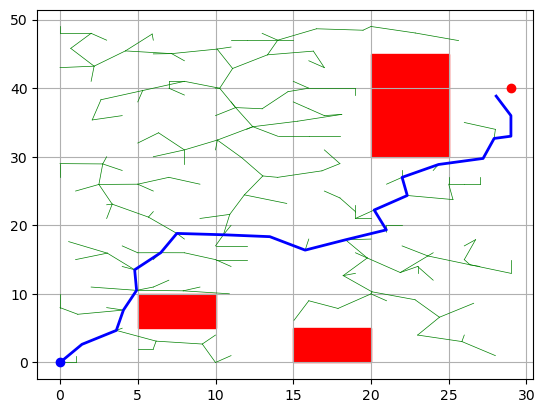

[<__main__.Node object at 0x7fc488f3ff40>, <__main__.Node object at 0x7fc488f3ffa0>, <__main__.Node object at 0x7fc488f3fe80>, <__main__.Node object at 0x7fc488f3fd30>, <__main__.Node object at 0x7fc488f3e560>, <__main__.Node object at 0x7fc488f3e350>, <__main__.Node object at 0x7fc488f3e7a0>, <__main__.Node object at 0x7fc488f3ed40>, <__main__.Node object at 0x7fc488f3e7d0>, <__main__.Node object at 0x7fc4892082e0>, <__main__.Node object at 0x7fc4892090c0>, <__main__.Node object at 0x7fc4893920b0>, <__main__.Node object at 0x7fc48b129930>, <__main__.Node object at 0x7fc48b129db0>, <__main__.Node object at 0x7fc48b12a4a0>, <__main__.Node object at 0x7fc48b12ad10>, <__main__.Node object at 0x7fc48b12b010>, <__main__.Node object at 0x7fc48b12b130>, <__main__.Node object at 0x7fc48b12b490>, <__main__.Node object at 0x7fc48b12b880>, <__main__.Node object at 0x7fc48b12be80>, <__main__.Node object at 0x7fc48b0ec730>, <__main__.Node object at 0x7fc48b0ed4b0>]


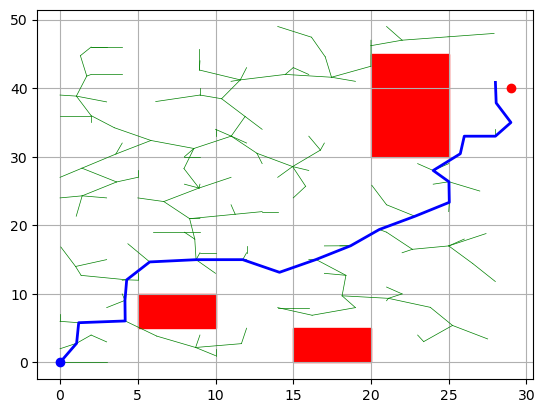

[<__main__.Node object at 0x7fc488ff6e30>, <__main__.Node object at 0x7fc4890476a0>, <__main__.Node object at 0x7fc4890477f0>, <__main__.Node object at 0x7fc489047cd0>, <__main__.Node object at 0x7fc489047d30>, <__main__.Node object at 0x7fc489047c40>, <__main__.Node object at 0x7fc489047a60>, <__main__.Node object at 0x7fc489047970>, <__main__.Node object at 0x7fc489047940>, <__main__.Node object at 0x7fc489047730>, <__main__.Node object at 0x7fc4890476d0>, <__main__.Node object at 0x7fc489441c60>, <__main__.Node object at 0x7fc489442c20>, <__main__.Node object at 0x7fc4894417e0>, <__main__.Node object at 0x7fc489442aa0>, <__main__.Node object at 0x7fc489440820>, <__main__.Node object at 0x7fc489440760>, <__main__.Node object at 0x7fc489440910>, <__main__.Node object at 0x7fc4894413f0>, <__main__.Node object at 0x7fc4893c3eb0>, <__main__.Node object at 0x7fc4893c2290>, <__main__.Node object at 0x7fc4893c1b40>, <__main__.Node object at 0x7fc4893c3d30>, <__main__.Node object at 0x7fc489

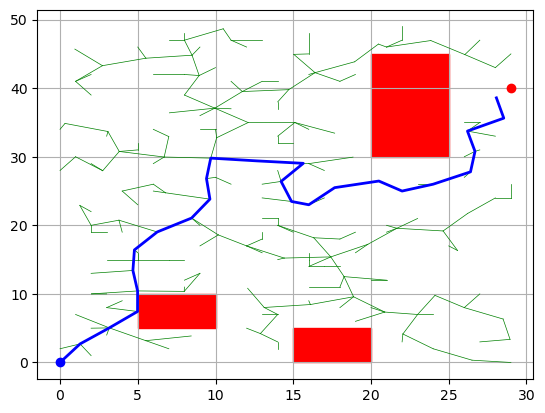

[<__main__.Node object at 0x7fc48b0eca30>, <__main__.Node object at 0x7fc48b0ec9a0>, <__main__.Node object at 0x7fc48b0ec910>, <__main__.Node object at 0x7fc488eeb610>, <__main__.Node object at 0x7fc488eeb3a0>, <__main__.Node object at 0x7fc488eeae30>, <__main__.Node object at 0x7fc488eeace0>, <__main__.Node object at 0x7fc488ee8880>, <__main__.Node object at 0x7fc488ee80a0>, <__main__.Node object at 0x7fc488ee96f0>, <__main__.Node object at 0x7fc488ee8760>, <__main__.Node object at 0x7fc488ee8700>, <__main__.Node object at 0x7fc488ee8b50>, <__main__.Node object at 0x7fc488ee9e70>, <__main__.Node object at 0x7fc48af4c880>, <__main__.Node object at 0x7fc488e8cb80>, <__main__.Node object at 0x7fc488e8ebf0>, <__main__.Node object at 0x7fc488e8f790>, <__main__.Node object at 0x7fc48919e7a0>, <__main__.Node object at 0x7fc48919c160>, <__main__.Node object at 0x7fc48919efb0>, <__main__.Node object at 0x7fc48919e680>, <__main__.Node object at 0x7fc488e6c760>, <__main__.Node object at 0x7fc488

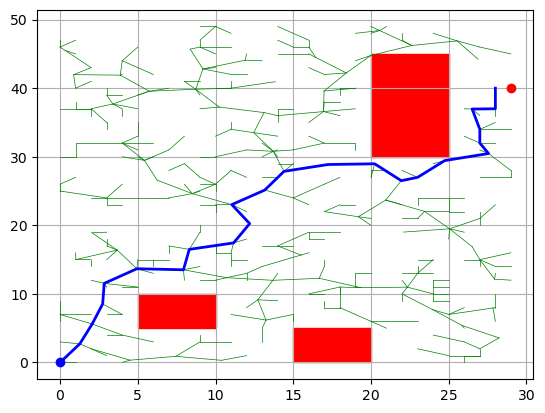

[<__main__.Node object at 0x7fc48d27f310>, <__main__.Node object at 0x7fc48d27c130>, <__main__.Node object at 0x7fc48d27c1f0>, <__main__.Node object at 0x7fc48d27d240>, <__main__.Node object at 0x7fc48d27d120>, <__main__.Node object at 0x7fc48d27c820>, <__main__.Node object at 0x7fc48d27f520>, <__main__.Node object at 0x7fc48d27d2a0>, <__main__.Node object at 0x7fc48d27e950>, <__main__.Node object at 0x7fc48d27e980>, <__main__.Node object at 0x7fc48d27e6e0>, <__main__.Node object at 0x7fc48d27d420>, <__main__.Node object at 0x7fc48d27d720>, <__main__.Node object at 0x7fc489443b20>, <__main__.Node object at 0x7fc489442c50>, <__main__.Node object at 0x7fc488ff6ce0>, <__main__.Node object at 0x7fc4891f4ee0>, <__main__.Node object at 0x7fc4891f5480>, <__main__.Node object at 0x7fc4891f6bc0>, <__main__.Node object at 0x7fc4891f4790>, <__main__.Node object at 0x7fc4891f7790>, <__main__.Node object at 0x7fc48918d600>, <__main__.Node object at 0x7fc48918da50>, <__main__.Node object at 0x7fc489

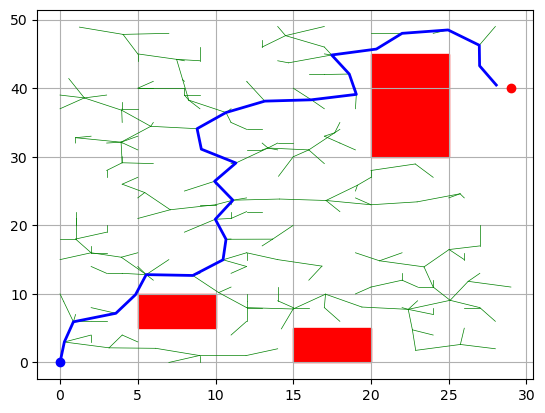

[<__main__.Node object at 0x7fc48afb1810>, <__main__.Node object at 0x7fc48afb16c0>, <__main__.Node object at 0x7fc48afb37f0>, <__main__.Node object at 0x7fc48afb3a60>, <__main__.Node object at 0x7fc48919f2e0>, <__main__.Node object at 0x7fc48af3bf70>, <__main__.Node object at 0x7fc48af3ab90>, <__main__.Node object at 0x7fc48af38a00>, <__main__.Node object at 0x7fc48af3a980>, <__main__.Node object at 0x7fc4893de2c0>, <__main__.Node object at 0x7fc4893de9e0>, <__main__.Node object at 0x7fc4893de3e0>, <__main__.Node object at 0x7fc4893df190>, <__main__.Node object at 0x7fc4893dc9d0>, <__main__.Node object at 0x7fc48af18a00>, <__main__.Node object at 0x7fc48926fe20>, <__main__.Node object at 0x7fc48926ccd0>, <__main__.Node object at 0x7fc48926db70>, <__main__.Node object at 0x7fc48926f610>, <__main__.Node object at 0x7fc48afc2f20>]


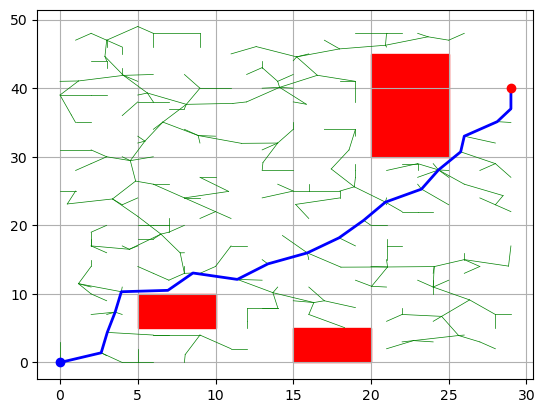

In [14]:
population = create_initial_population(population_size=20, plot_paths=True)

Generation: 1
Fitness: 0.0180613212304097


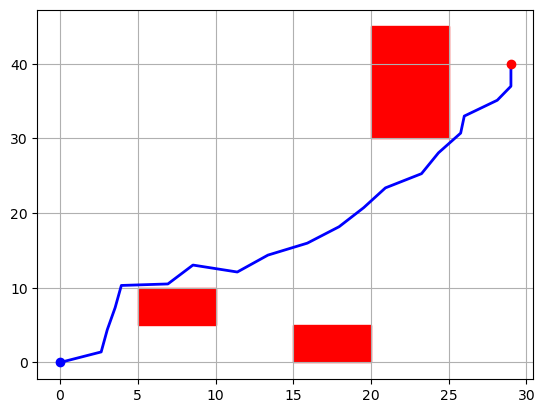

Generation: 2
Fitness: 0.017982941706536786


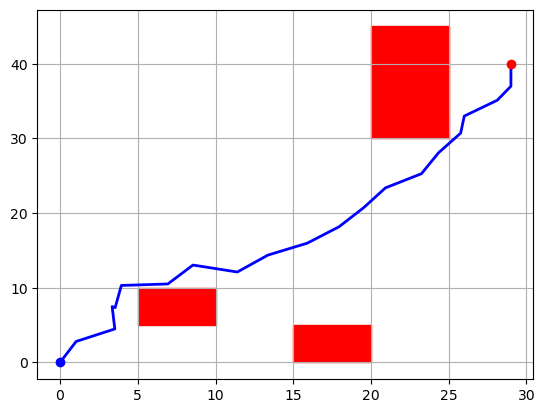

Generation: 3
Fitness: 0.017953775403624465


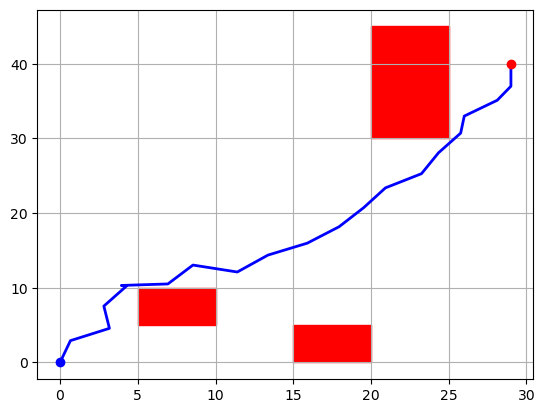

Generation: 4
Fitness: 0.017770964102260384


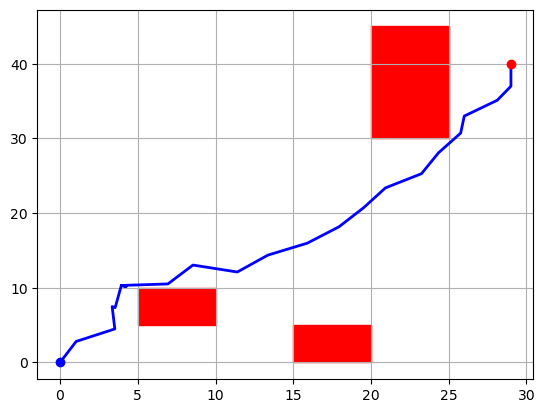

Generation: 5
Fitness: 0.017953775403624465


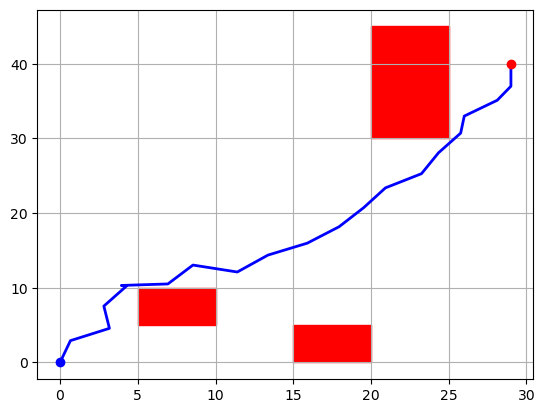

Generation: 6
Fitness: 0.017770964102260384


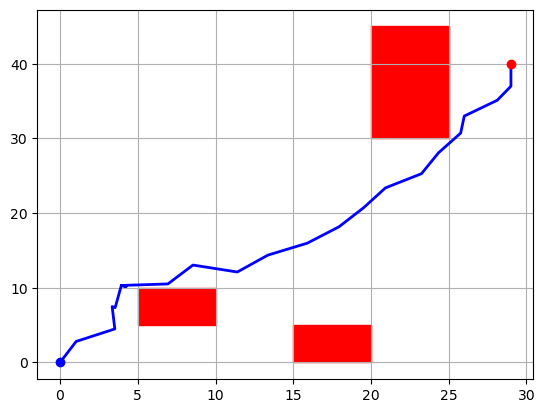

Generation: 7
Fitness: 0.017953775403624465


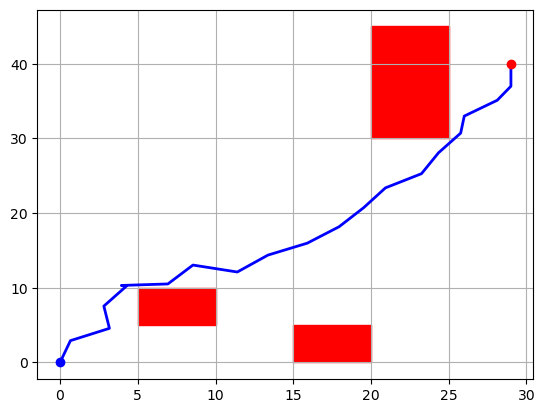

Generation: 8
Fitness: 0.017770964102260384


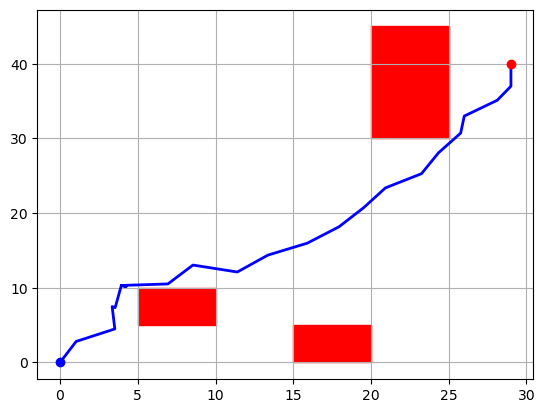

Generation: 9
Fitness: 0.017953775403624465


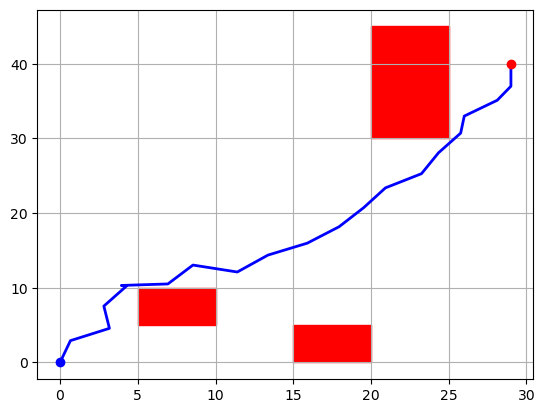

Generation: 10
Fitness: 0.017770964102260384


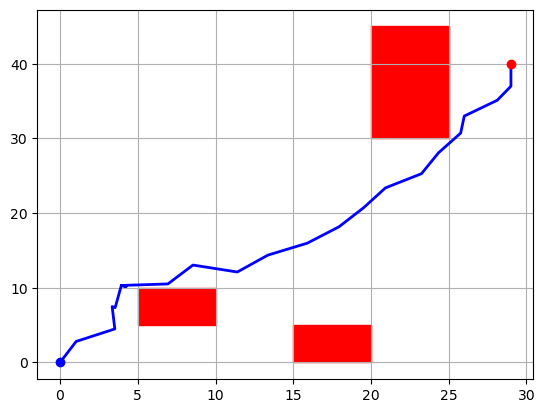

Generation: 11
Fitness: 0.017953775403624465


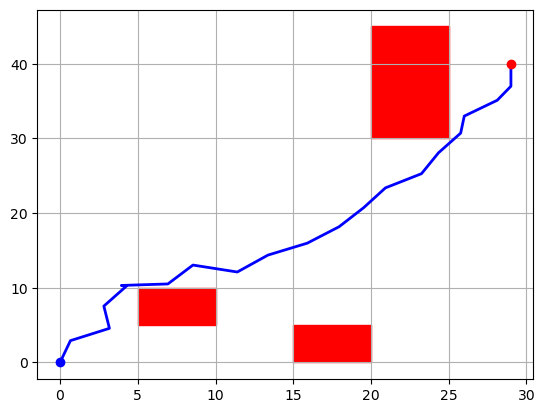

Generation: 12
Fitness: 0.017770964102260384


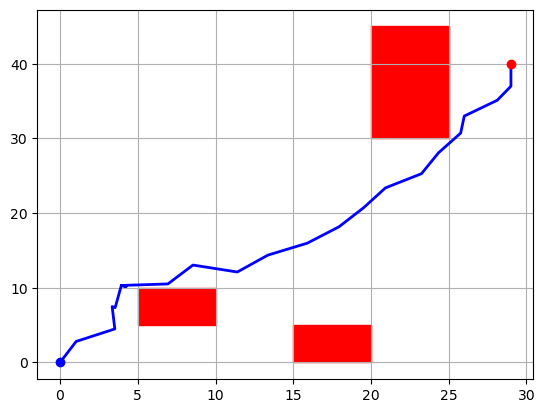

Generation: 13
Fitness: 0.017953775403624465


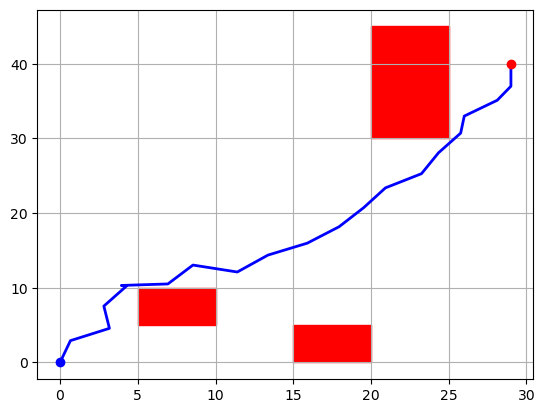

Generation: 14
Fitness: 0.017770964102260384


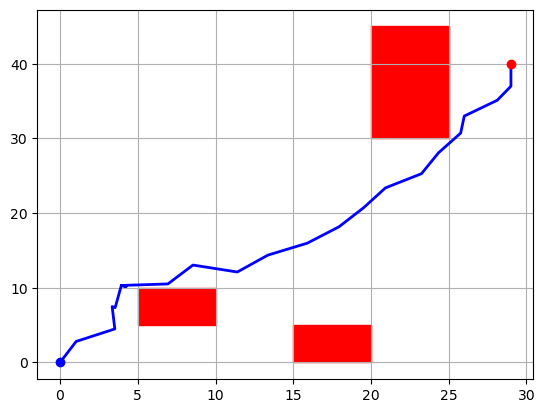

Generation: 15
Fitness: 0.017953775403624465


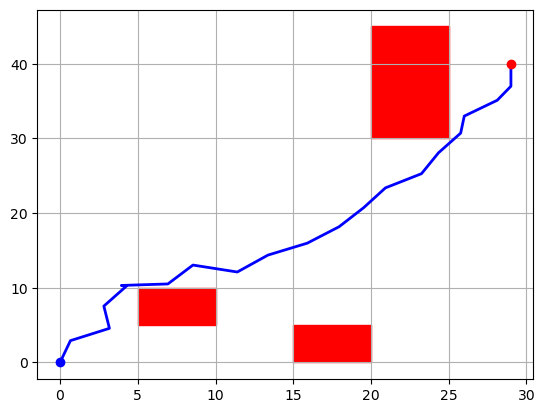

Generation: 16
Fitness: 0.017770964102260384


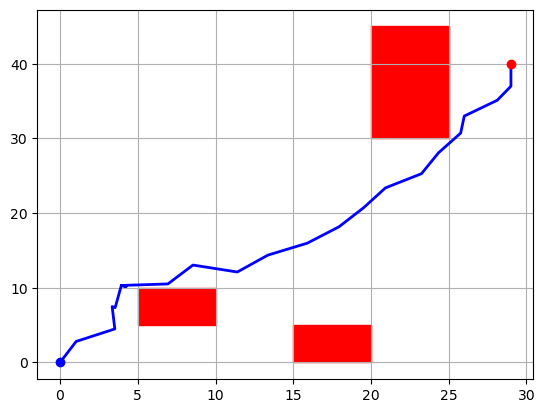

Generation: 17
Fitness: 0.017953775403624465


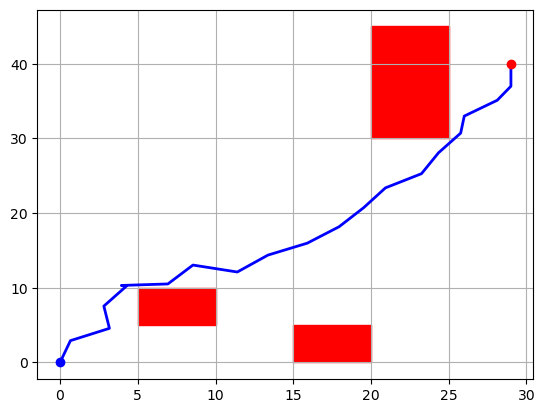

Generation: 18
Fitness: 0.017770964102260384


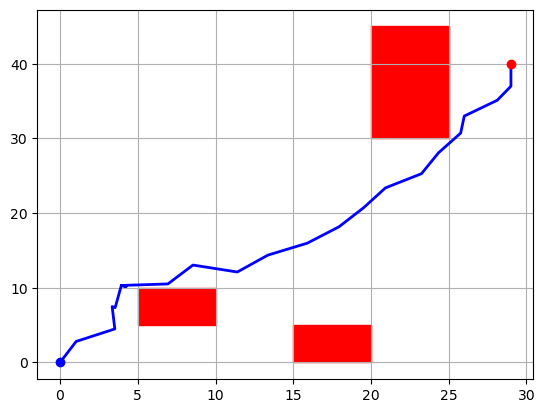

Generation: 19
Fitness: 0.017953775403624465


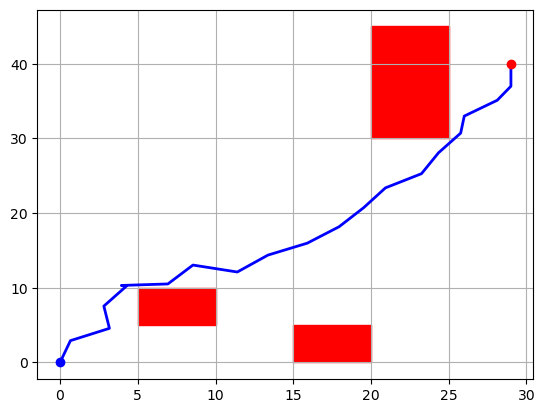

Generation: 20
Fitness: 0.017770964102260384


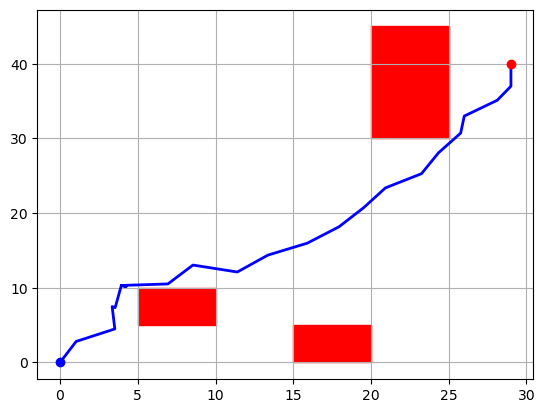

Generation: 21
Fitness: 0.017953775403624465


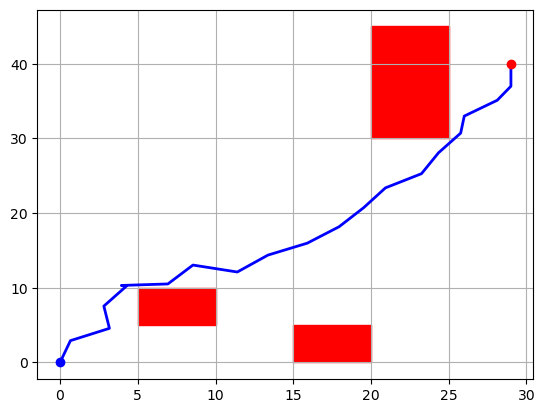

Generation: 22
Fitness: 0.017770964102260384


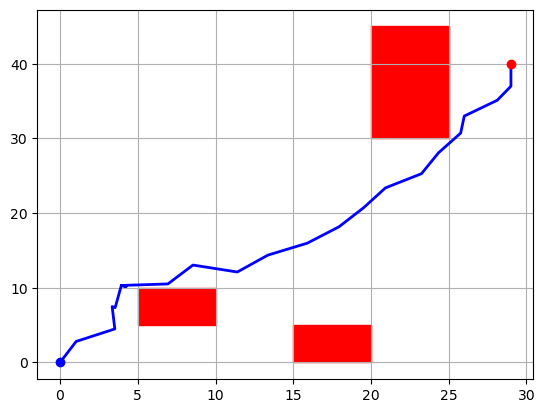

Generation: 23
Fitness: 0.017953775403624465


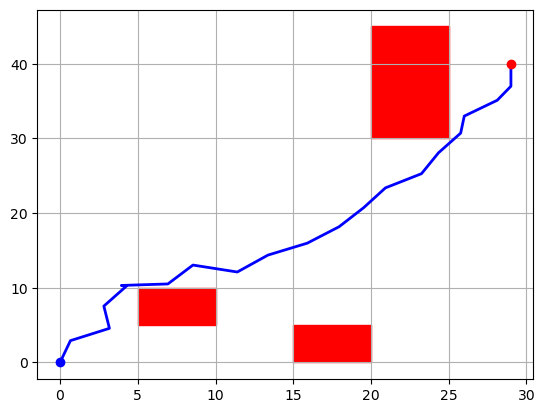

Generation: 24
Fitness: 0.017770964102260384


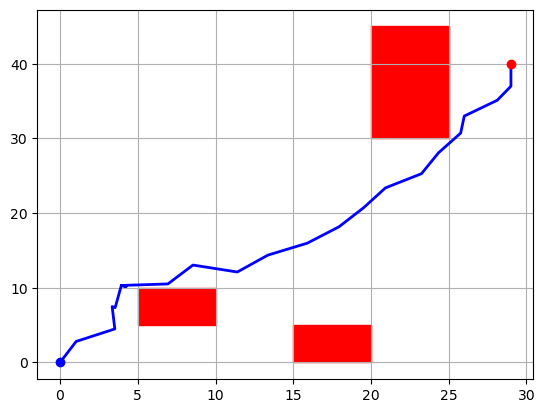

Generation: 25
Fitness: 0.017953775403624465


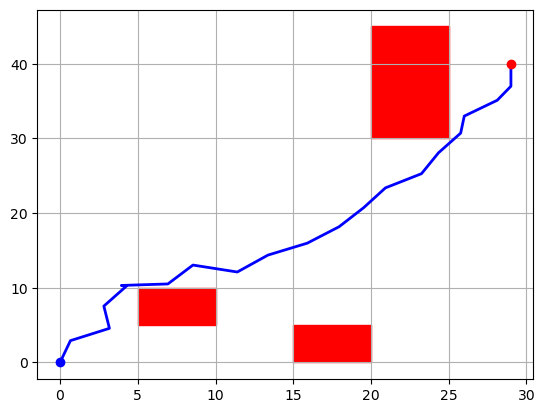

Generation: 26
Fitness: 0.017770964102260384


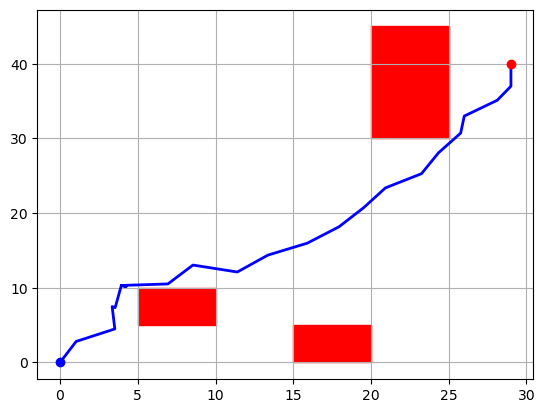

Generation: 27
Fitness: 0.017953775403624465


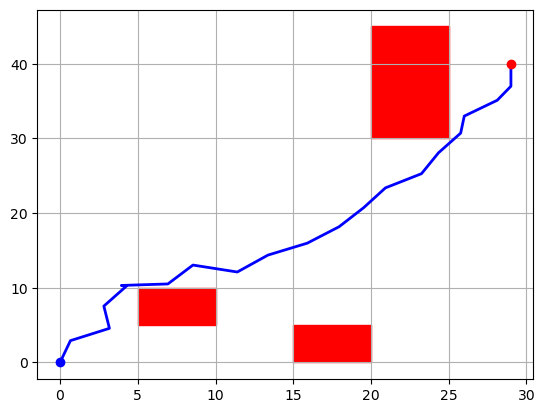

Generation: 28
Fitness: 0.017770964102260384


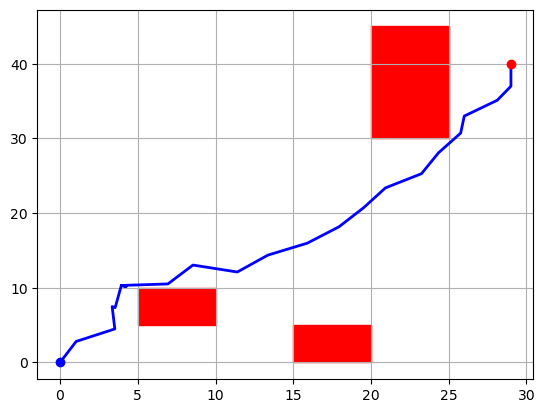

Generation: 29
Fitness: 0.017953775403624465


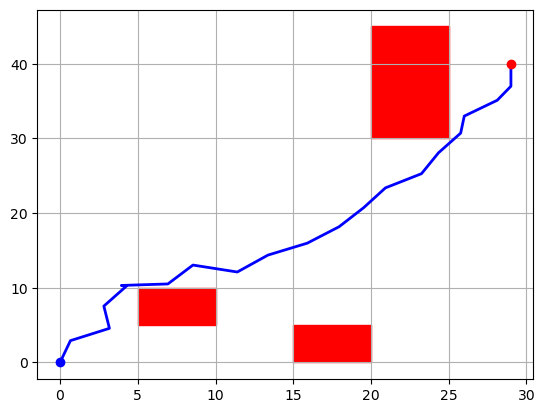

Generation: 30
Fitness: 0.017770964102260384


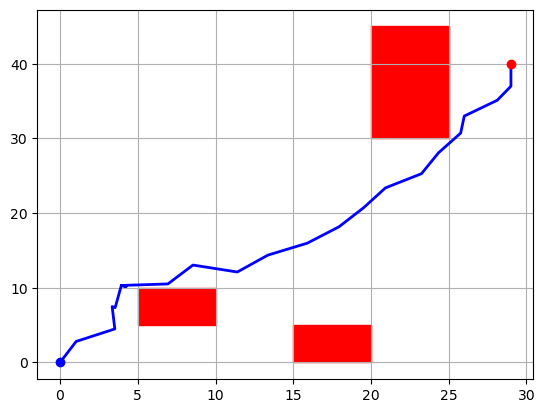

Generation: 31
Fitness: 0.017953775403624465


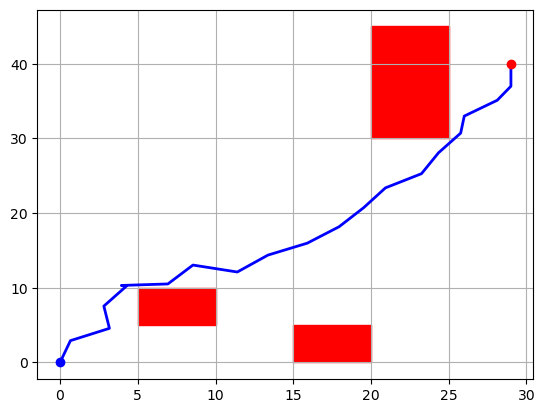

Generation: 32
Fitness: 0.017770964102260384


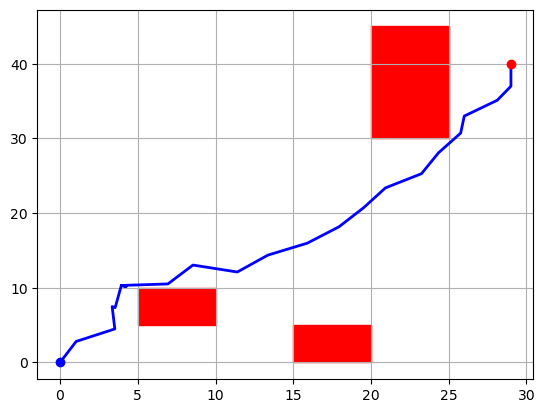

Generation: 33
Fitness: 0.017953775403624465


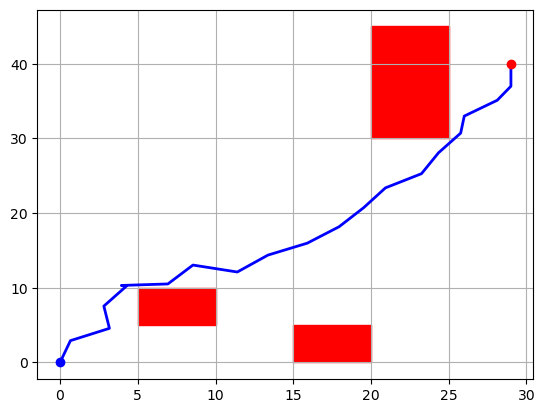

Generation: 34
Fitness: 0.017770964102260384


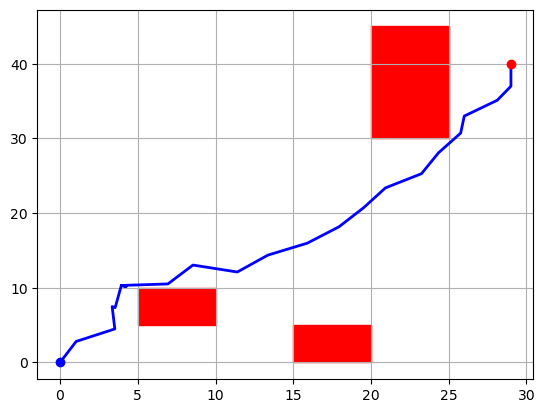

Generation: 35
Fitness: 0.017953775403624465


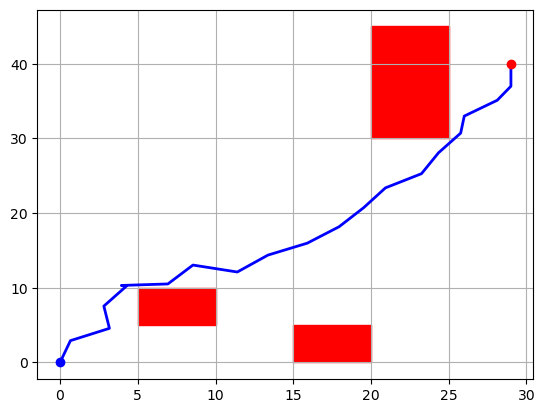

Generation: 36
Fitness: 0.017770964102260384


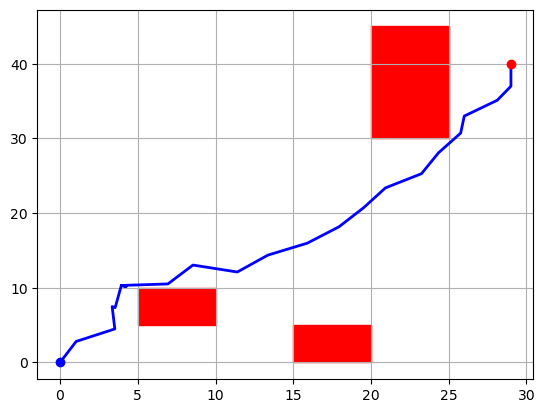

Generation: 37
Fitness: 0.017953775403624465


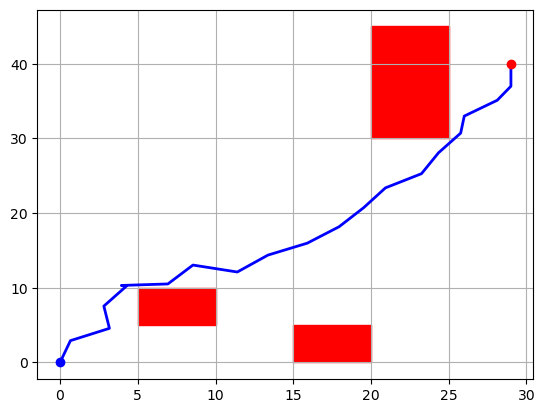

Generation: 38
Fitness: 0.017770964102260384


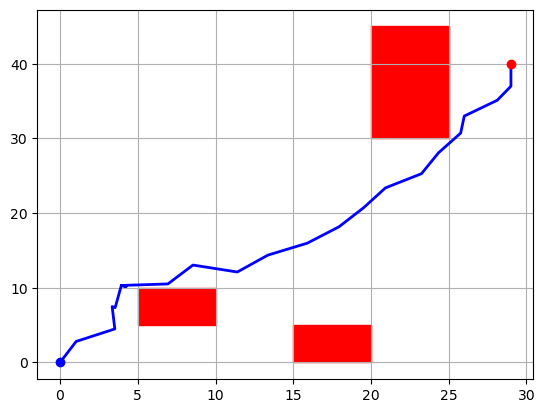

Generation: 39
Fitness: 0.017953775403624465


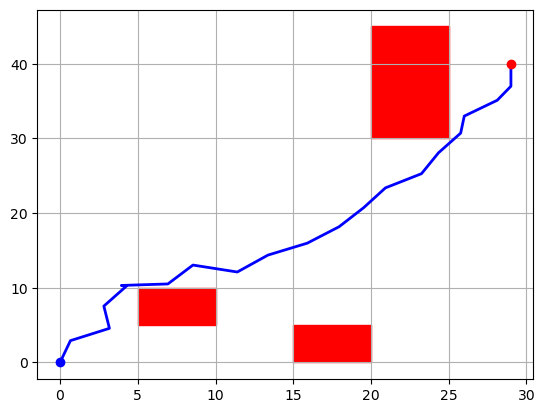

Generation: 40
Fitness: 0.017770964102260384


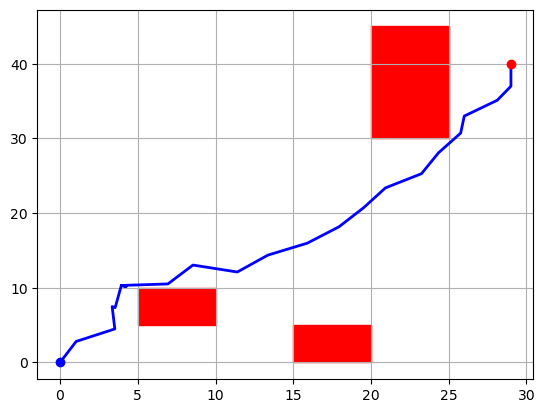

Generation: 41
Fitness: 0.017953775403624465


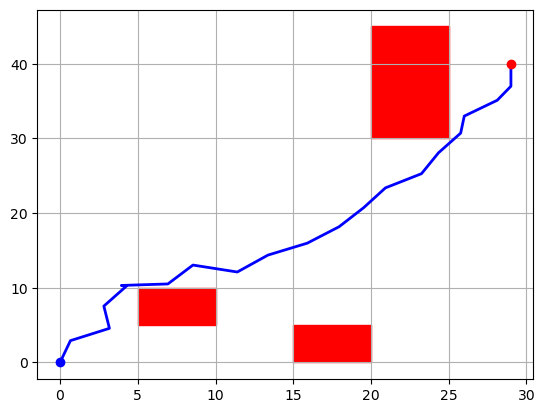

Generation: 42
Fitness: 0.017770964102260384


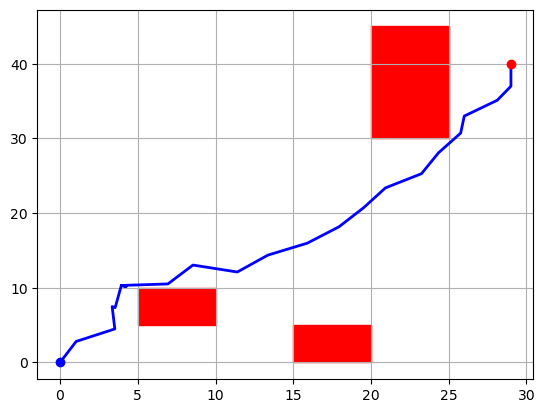

Generation: 43
Fitness: 0.017953775403624465


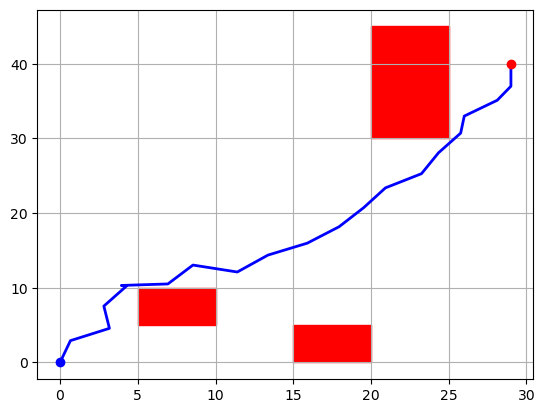

Generation: 44
Fitness: 0.017770964102260384


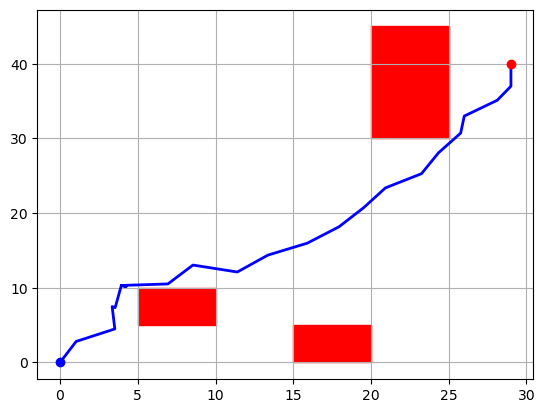

Generation: 45
Fitness: 0.017953775403624465


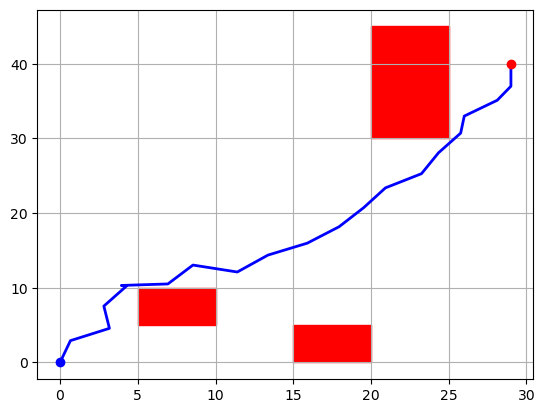

Generation: 46
Fitness: 0.017770964102260384


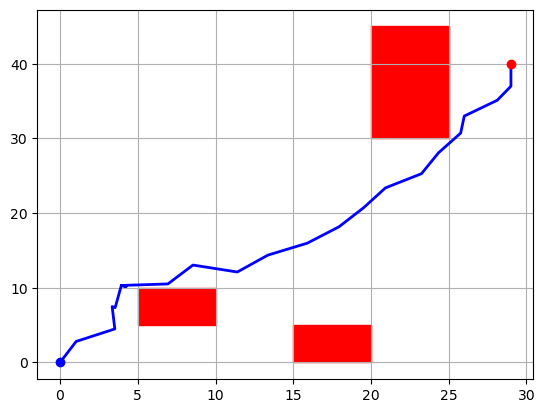

Generation: 47
Fitness: 0.017953775403624465


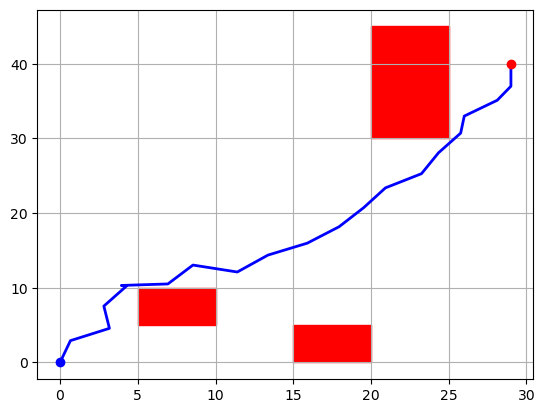

Generation: 48
Fitness: 0.017770964102260384


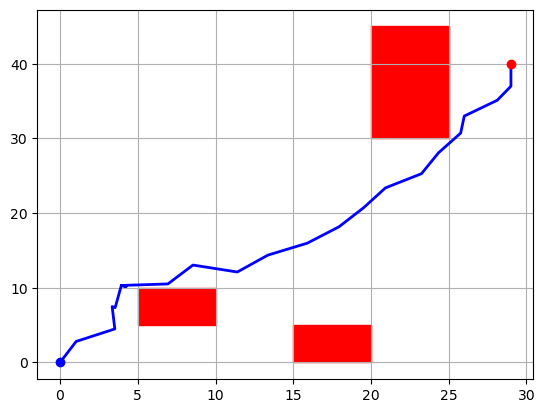

Generation: 49
Fitness: 0.017953775403624465


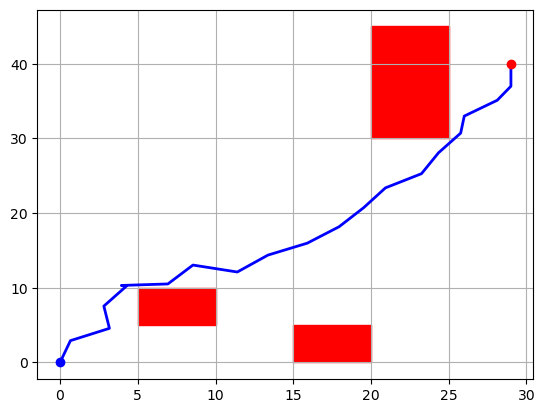

Generation: 50
Fitness: 0.017770964102260384


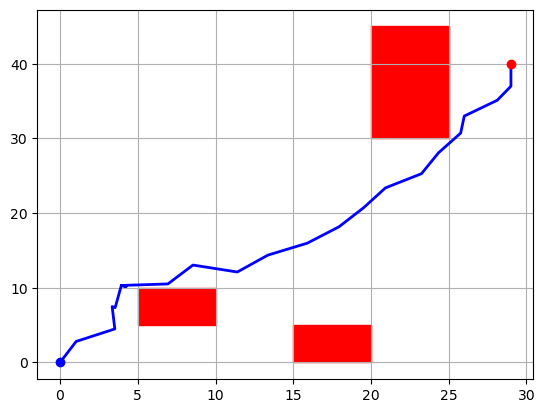

Generation: 51
Fitness: 0.017953775403624465


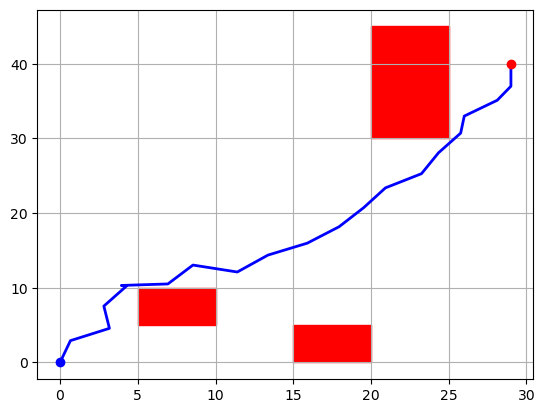

Generation: 52
Fitness: 0.017770964102260384


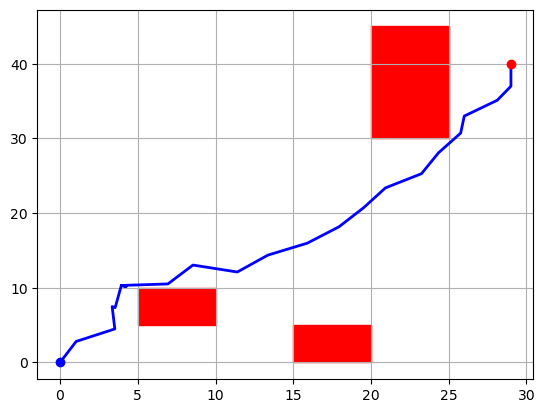

Generation: 53
Fitness: 0.017953775403624465


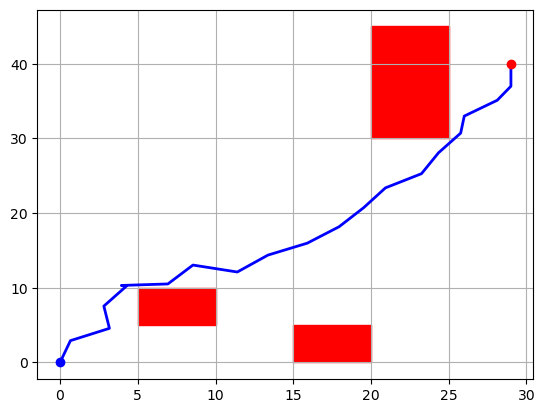

Generation: 54
Fitness: 0.017770964102260384


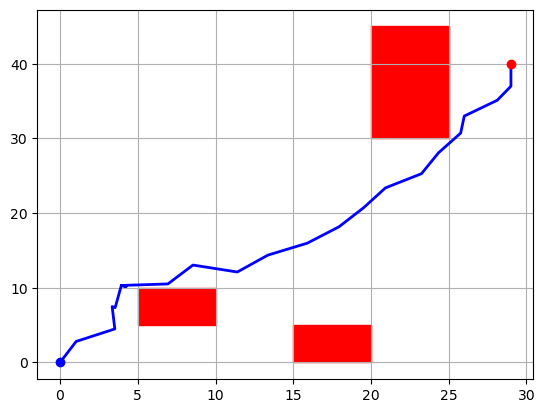

Generation: 55
Fitness: 0.017953775403624465


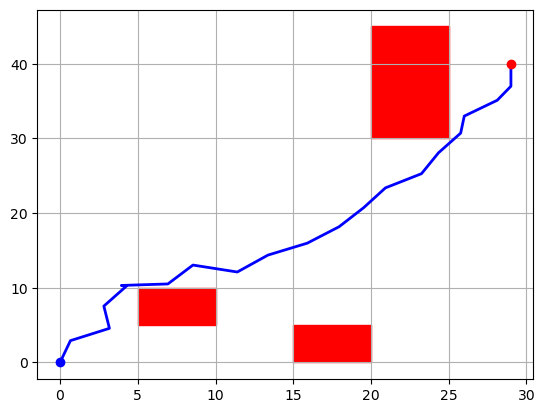

Generation: 56
Fitness: 0.017770964102260384


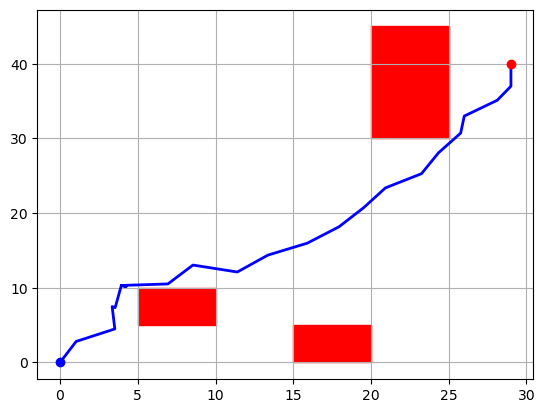

Generation: 57
Fitness: 0.017953775403624465


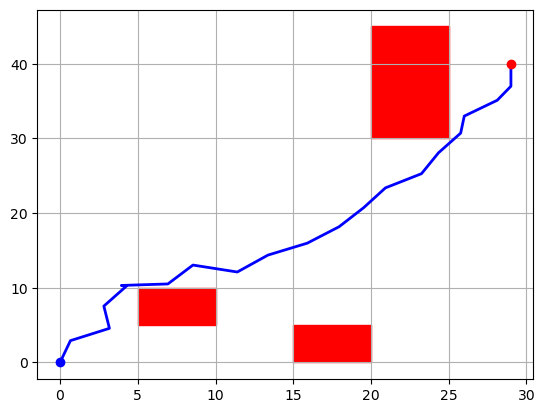

Generation: 58
Fitness: 0.017770964102260384


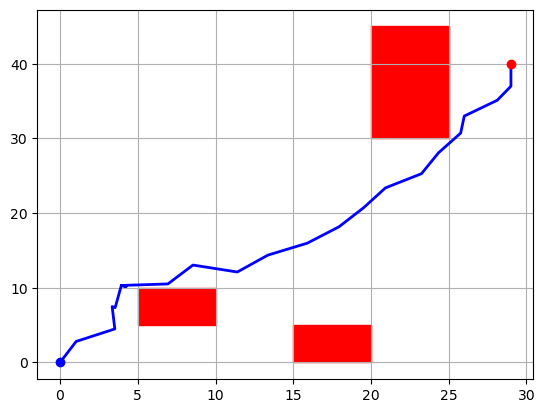

Generation: 59
Fitness: 0.017953775403624465


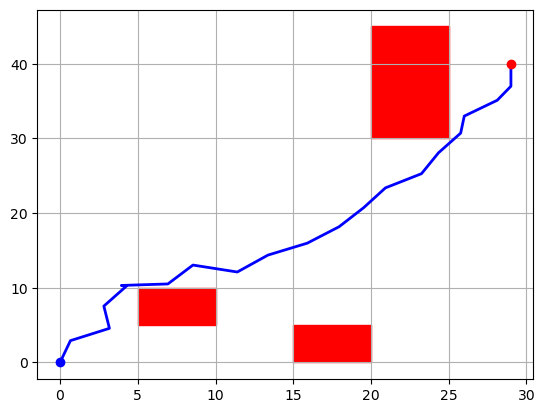

Generation: 60
Fitness: 0.017770964102260384


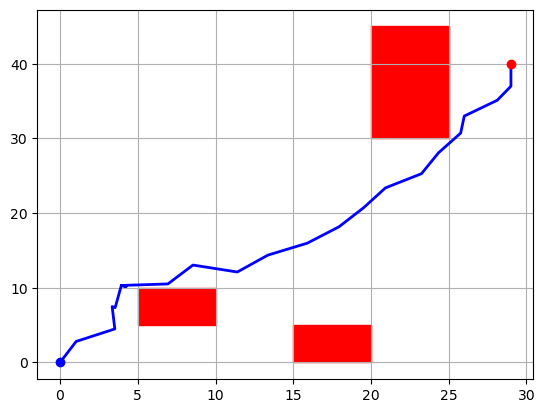

Generation: 61
Fitness: 0.017953775403624465


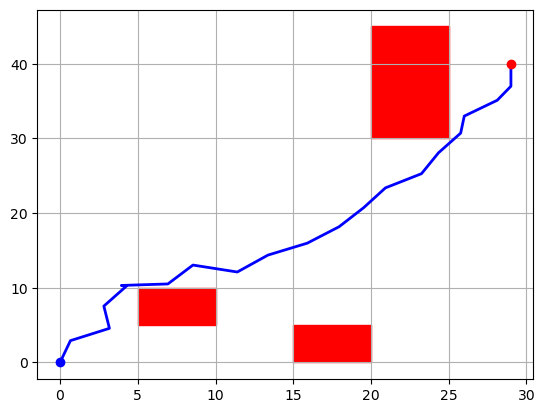

Generation: 62
Fitness: 0.017770964102260384


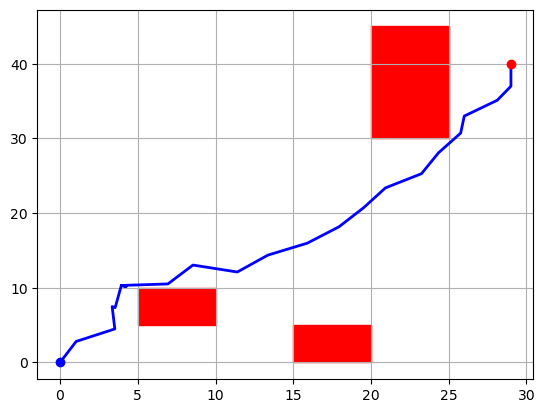

Generation: 63
Fitness: 0.017953775403624465


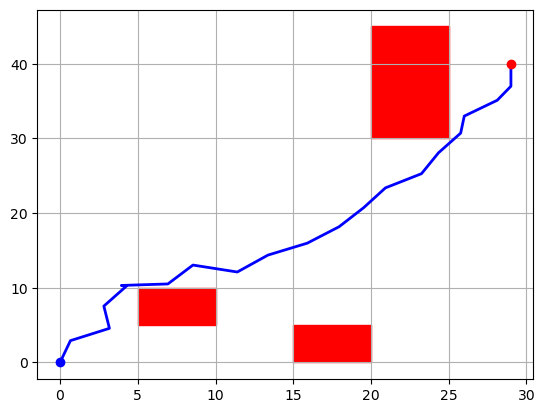

Generation: 64
Fitness: 0.017770964102260384


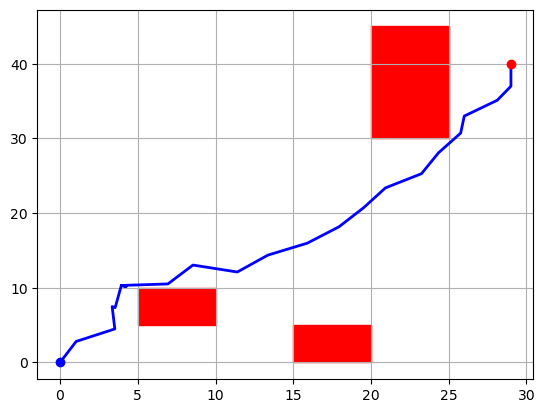

Generation: 65
Fitness: 0.017953775403624465


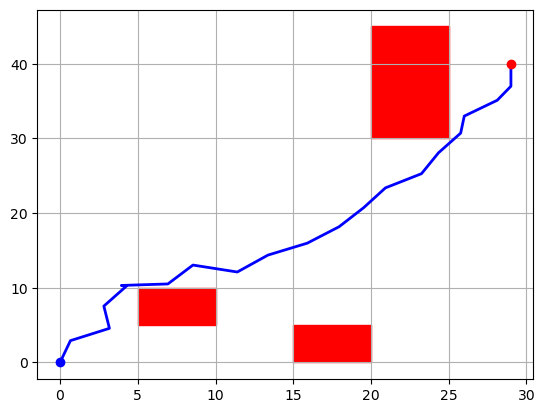

Generation: 66
Fitness: 0.017770964102260384


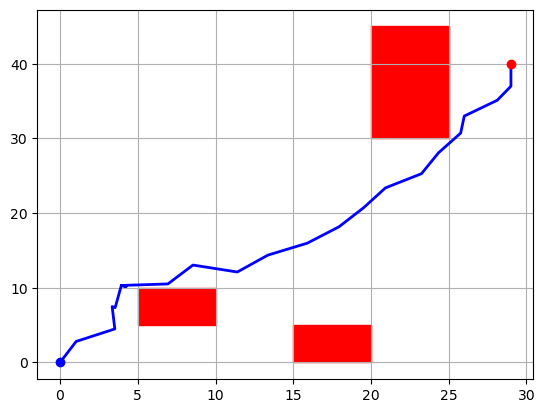

Generation: 67
Fitness: 0.017953775403624465


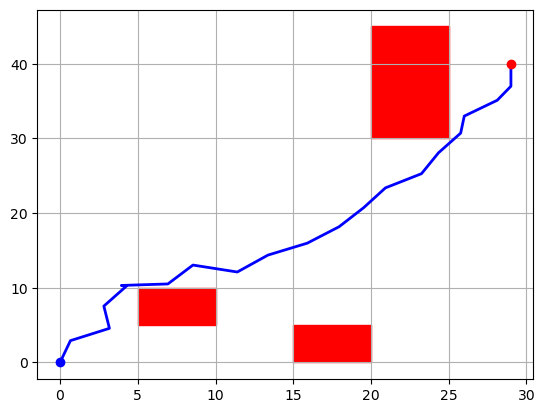

Generation: 68
Fitness: 0.017770964102260384


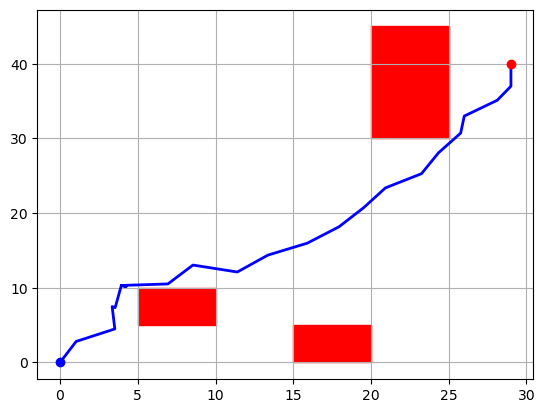

Generation: 69
Fitness: 0.017953775403624465


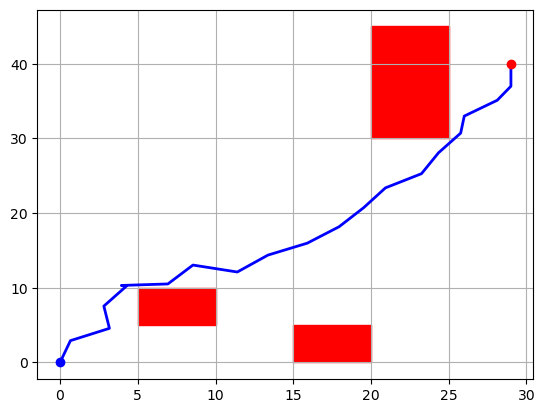

Generation: 70
Fitness: 0.017770964102260384


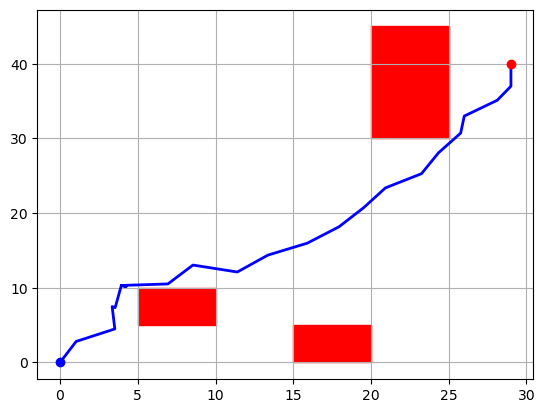

Generation: 71
Fitness: 0.017953775403624465


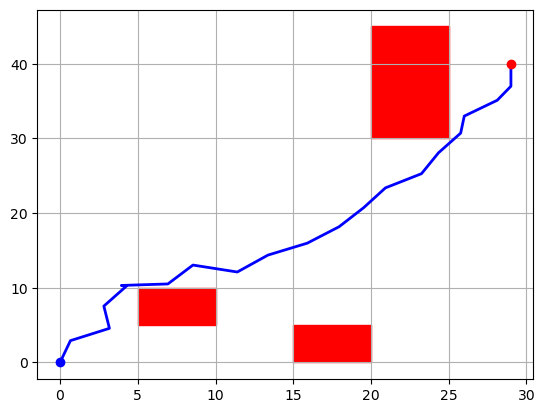

Generation: 72
Fitness: 0.017770964102260384


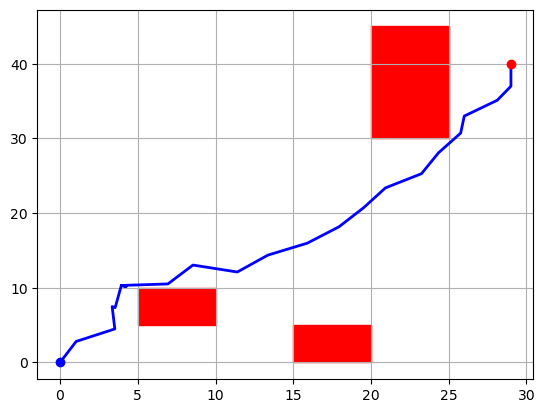

Generation: 73
Fitness: 0.017953775403624465


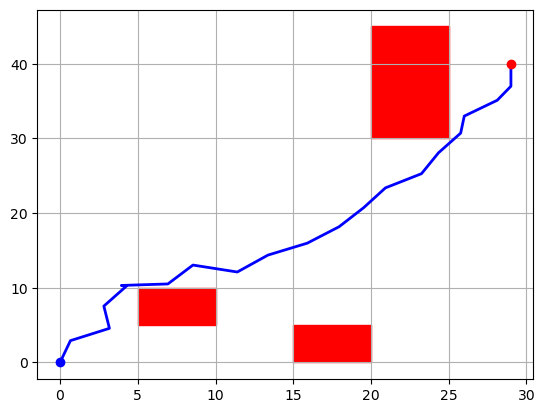

Generation: 74
Fitness: 0.017770964102260384


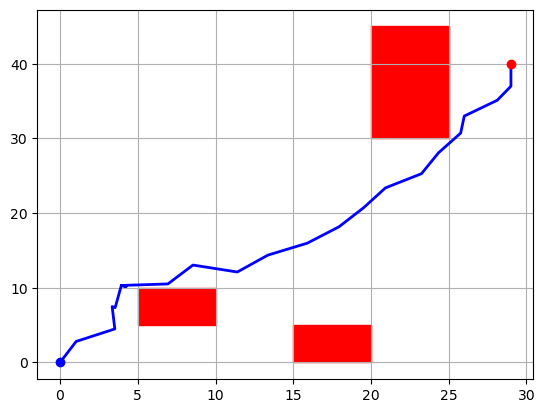

Generation: 75
Fitness: 0.017953775403624465


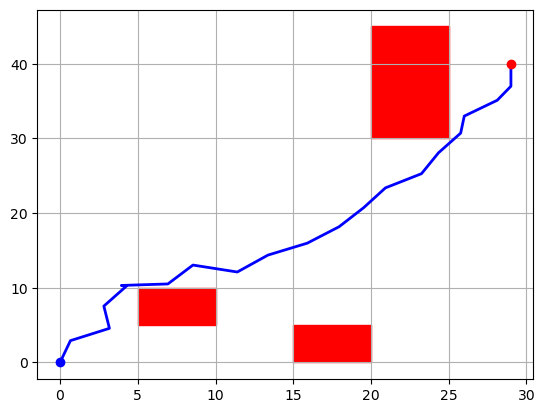

Generation: 76
Fitness: 0.017770964102260384


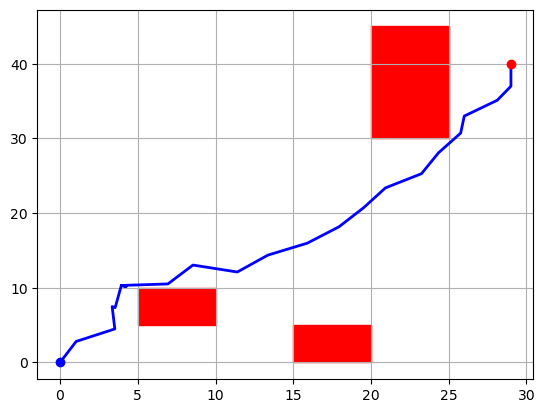

Generation: 77
Fitness: 0.017953775403624465


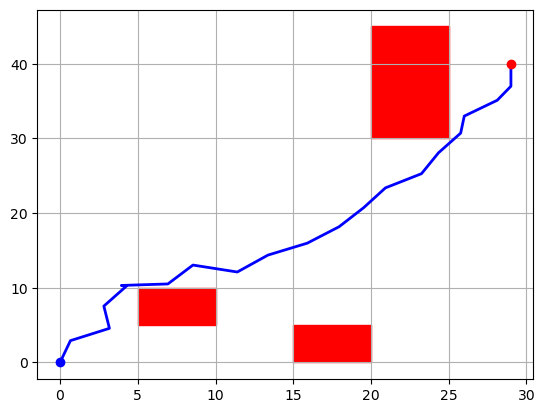

Generation: 78
Fitness: 0.017770964102260384


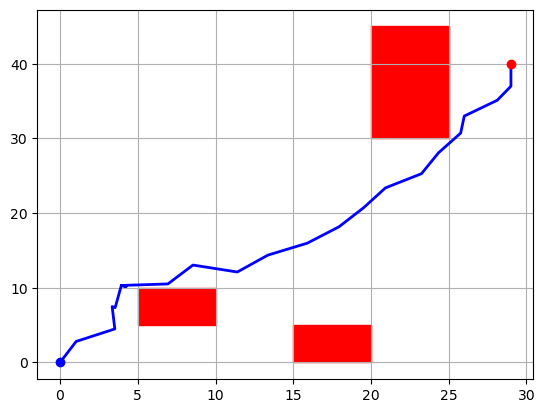

Generation: 79
Fitness: 0.017953775403624465


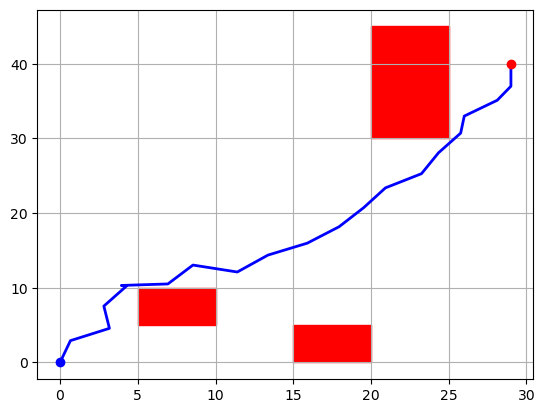

Generation: 80
Fitness: 0.017770964102260384


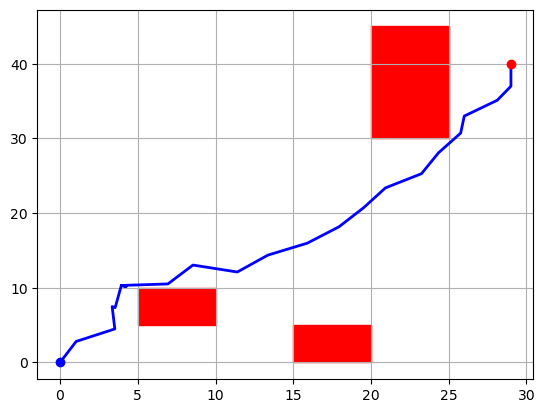

Generation: 81
Fitness: 0.017953775403624465


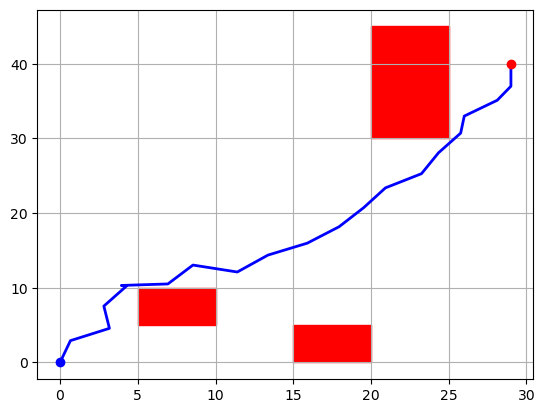

Generation: 82
Fitness: 0.017770964102260384


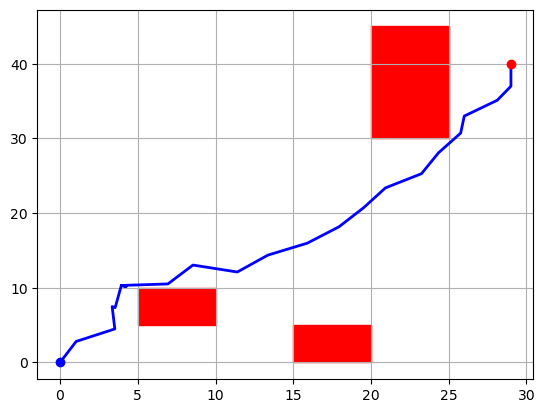

Generation: 83
Fitness: 0.017953775403624465


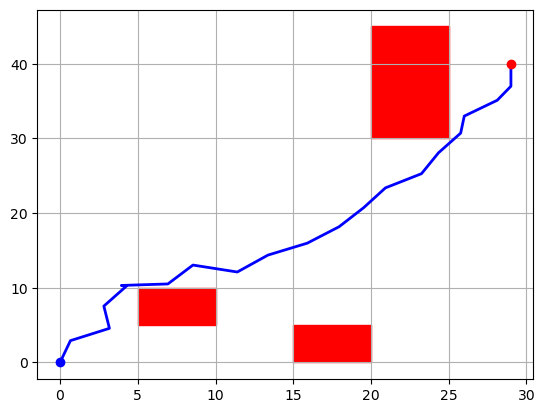

Generation: 84
Fitness: 0.017770964102260384


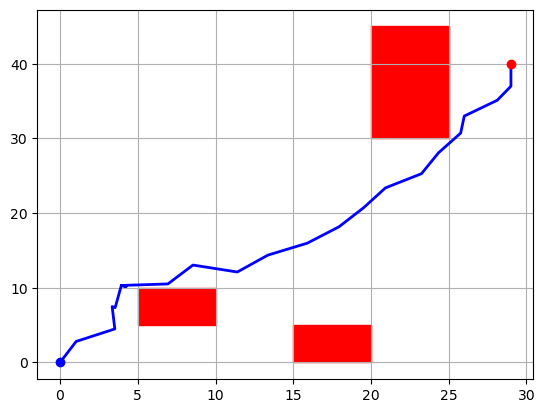

Generation: 85
Fitness: 0.017953775403624465


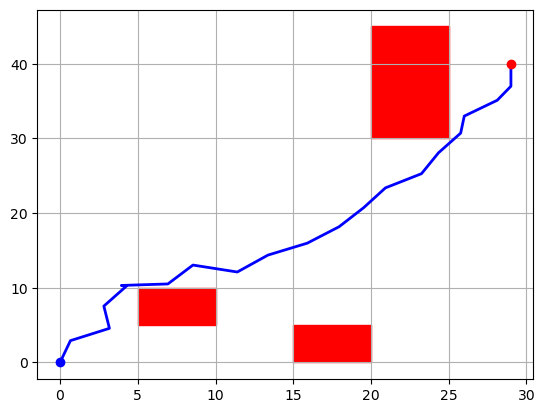

Generation: 86
Fitness: 0.017770964102260384


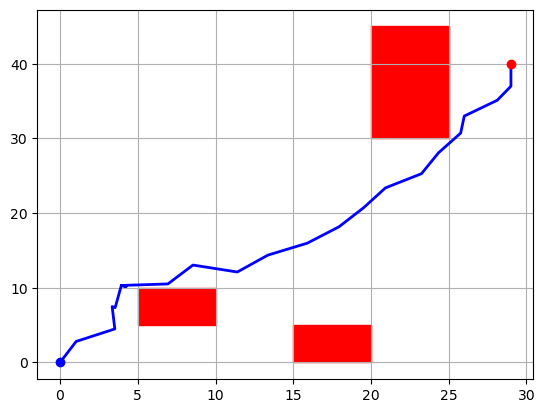

Generation: 87
Fitness: 0.017953775403624465


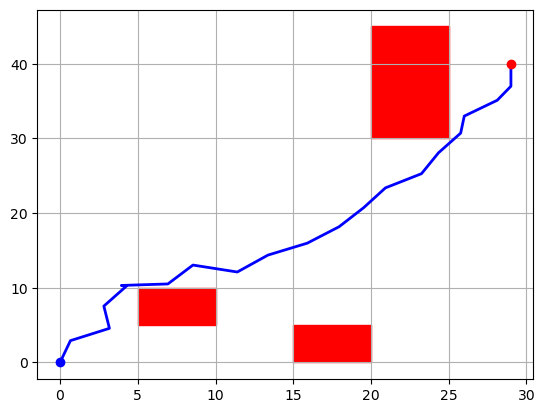

Generation: 88
Fitness: 0.017770964102260384


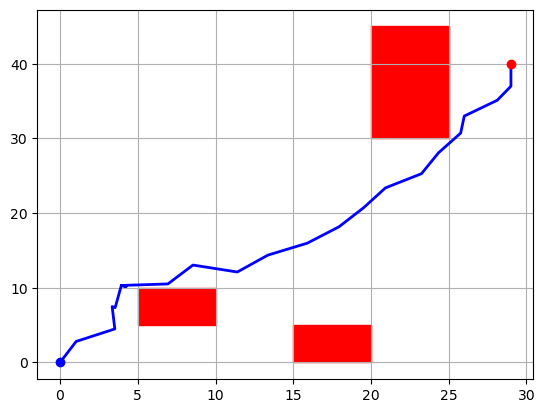

Generation: 89
Fitness: 0.017953775403624465


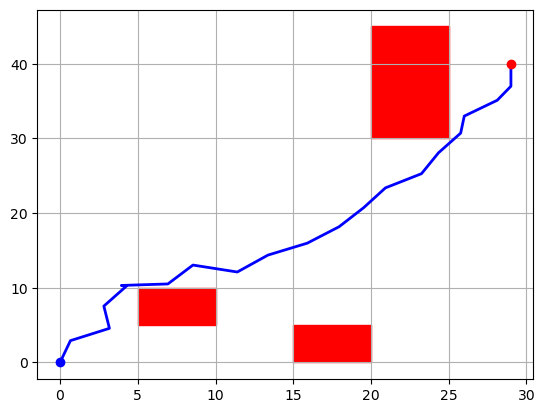

Generation: 90
Fitness: 0.017770964102260384


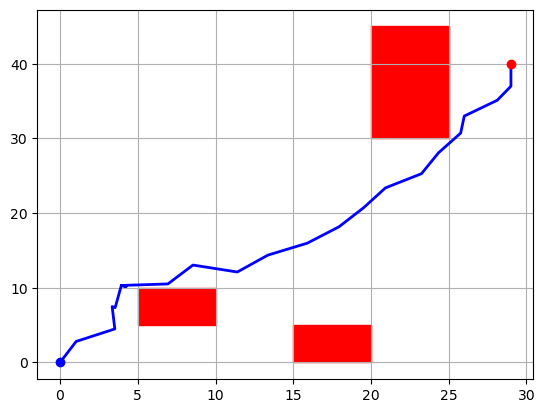

Generation: 91
Fitness: 0.017953775403624465


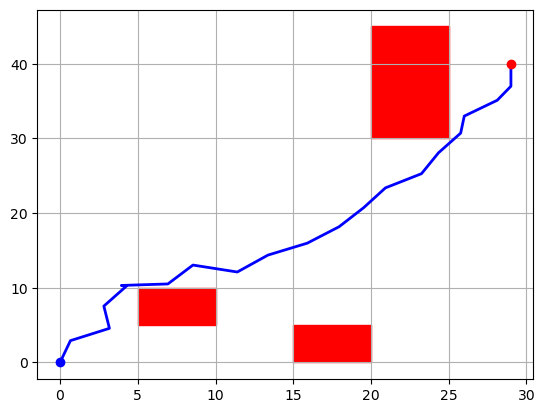

Generation: 92
Fitness: 0.017770964102260384


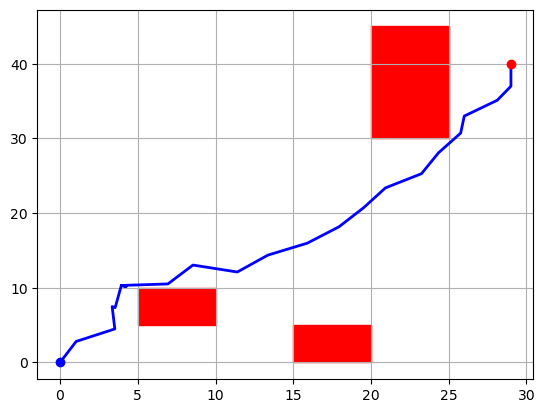

Generation: 93
Fitness: 0.017953775403624465


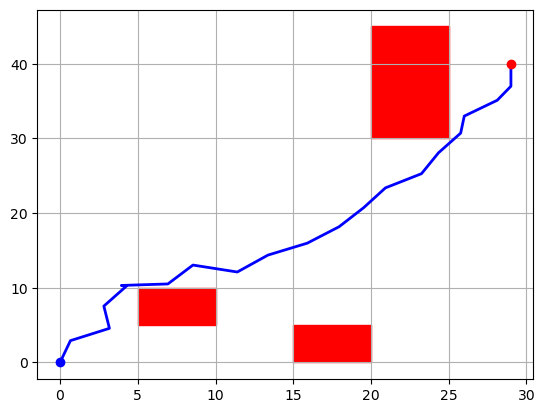

Generation: 94
Fitness: 0.017770964102260384


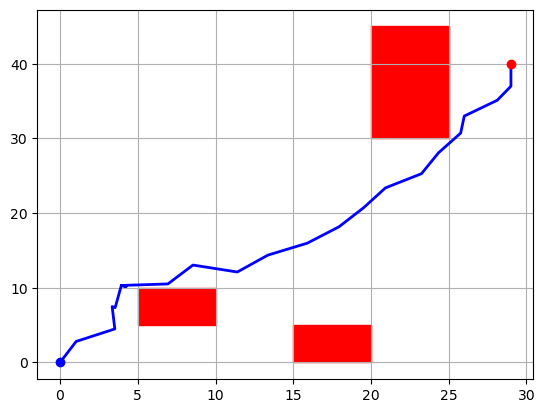

Generation: 95
Fitness: 0.017953775403624465


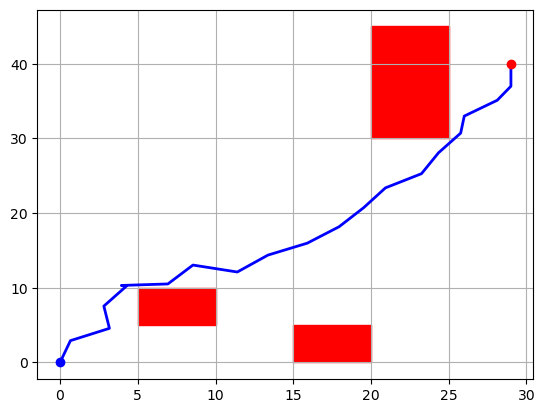

Generation: 96
Fitness: 0.017770964102260384


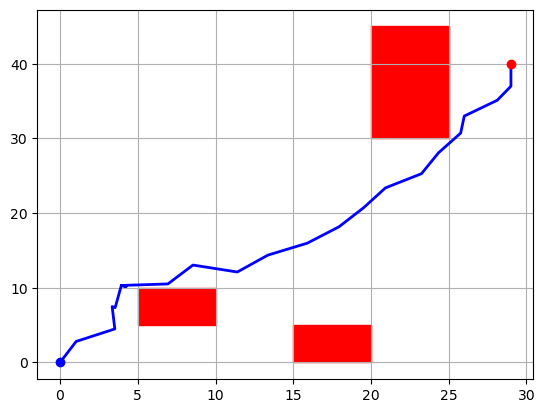

Generation: 97
Fitness: 0.017953775403624465


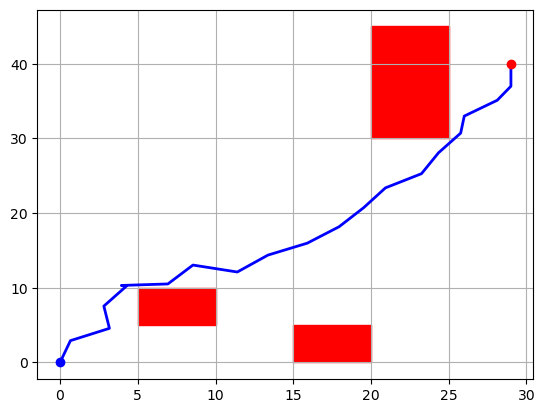

Generation: 98
Fitness: 0.017770964102260384


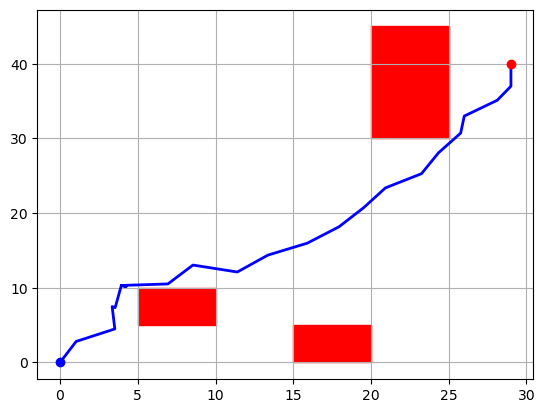

Generation: 99
Fitness: 0.017953775403624465


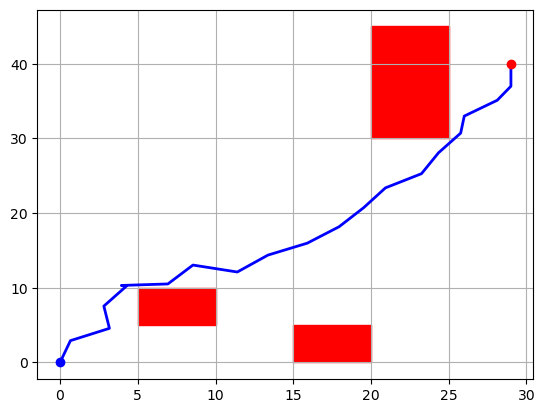

Generation: 100
Fitness: 0.017770964102260384


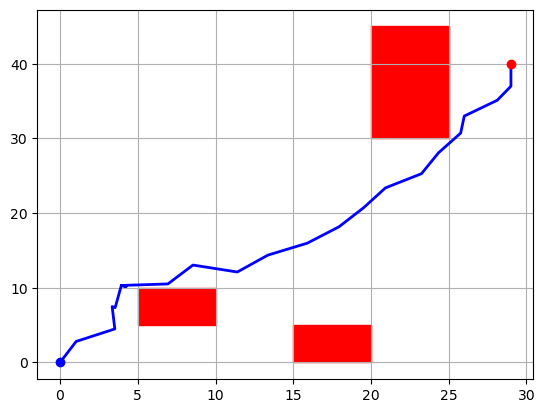

In [15]:
for gen in range (1,101):
  print(f"Generation: {gen}")
  if population:
    fitness = calcualte_fitness_of_population(population)
    # fitness, population = elimination(fitness, population)
    best_fitness = plot_best_solution(fitness=fitness, population=population, plot_graph=True)
    P1, P2 = best_selection(fitness, population)
    for i in range(0,len(P1)):
      try:
        offspring1 , offspring2 = crossoverpt(P1[i], P2[i])
      except:
        pass
        print(f"Failed for parent set {i}")
        # plot(path=P1[i])
        # plot(path=P2[i])

      population.append(offspring1)
      population.append(offspring2)
  else:
    print(f"Termination at generation: {gen}")

In [16]:
# fitness, population = elimination(fitness, population)

In [17]:
# plot(path=P1[0])
# plot(path=P2[0])
# plot(path=offspring1)
# plot(path=offspring2)